# Profiling

The current notebook's purpose is to segment customers by creating customer profiles based on their individual behavior. The reasoning behind profiling is twofold:
- Allow outlining the current business' customer segmentation
- Support business decisions in terms of marketing and customer targeting

In [1]:
from itertools import chain, combinations
from operator import itemgetter 

from collections import defaultdict
from typing import Any, Dict, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

from scipy import stats
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [4]:
def analyze_skewness(x):
    data = rfm_table.loc[rfm_table[x] > 0, x]

    print('--', x, '--')
    fig, ax = plt.subplots(3, 2, figsize=(15,8))
    
    sns.histplot(data, ax=ax[0,0])
    sns.histplot(np.log(data.replace(0, np.nan)), ax=ax[0,1])
    sns.histplot(np.sqrt(data), ax=ax[1,0])
    sns.histplot(stats.boxcox(data.replace(0, np.nan))[0], ax=ax[1,1])
    sns.histplot(np.cbrt(data), ax=ax[2,0])
    plt.tight_layout()
    plt.show()

    skewness_results: List[Dict] = []

    skewness_results.append({'Model': 'None', 'Skewness':data.skew().round(2)})
    skewness_results.append({'Model': 'Log', 'Skewness': np.log(data.replace(0, np.nan)).skew().round(2)})
    skewness_results.append({'Model': 'Square Root', 'Skewness': np.sqrt(data).skew().round(2)})
    skewness_results.append({'Model': 'Box-Cox', 'Skewness': pd.Series(stats.boxcox(data.replace(0, np.nan))[0]).skew().round(2)})
    skewness_results.append({'Model': 'Cubic Root', 'Skewness': np.cbrt(data).skew().round(2)})

    plt.show()
    print(pd.DataFrame.from_dict(skewness_results))
    

def plot_feature_importance(model) -> None:
    features_data: Dict[str, Any] = {'features': x.columns, 'feature_importance': model.feature_importances_}
    fd: pd.DataFrame = pd.DataFrame(features_data)
    fd.sort_values(by=['feature_importance'], ascending= False, inplace=True)
    
    sns.barplot(x = fd.feature_importance, y= fd.features)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature name');
    
    plt.show()
    
def plot_permutation_importance(model, x: pd.DataFrame, Y: pd.DataFrame) -> None:  
    # the permutation based importance is model agnostic and terribly slow
    perm_importance = permutation_importance(model, x, Y)
    
    features_data: Dict[str, Any] = {'features': x.columns, 'feature_importance': perm_importance.importances_mean}
    fd: pd.DataFrame = pd.DataFrame(features_data)
    fd.sort_values(by=['feature_importance'], ascending= False, inplace=True)
    
    sns.barplot(x = fd.feature_importance, y= fd.features)
    plt.xlabel("Permutation Importance")
    plt.ylabel('Feature name');
    
    plt.show()
    
def plot_shap_importance(model, x:pd.DataFrame) -> None:
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    shap.summary_plot(shap_values, x, plot_type="bar")
    
def all_subsets(ss):
    # Generates all combinations of features without replacement
    # and with outsampling
    return chain(*map(lambda x: combinations(ss, x), range(0, len(ss)+1)))

def plot_silhouette(data: pd.DataFrame, min_clusters= 2, max_clusters = 11) -> None:
    for i, k in enumerate(range(min_clusters, max_clusters +1)):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20, 7)

        # Run the Kmeans algorithm
        km = KMeans(n_clusters= k, random_state = 30)
        labels = km.fit_predict(data)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = metrics.silhouette_samples(data, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);

        # Scatter plot of data colored with labels
        ax2.scatter(data[:, 0], data[:, 1], c=labels)
        ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
        ax2.set_xlim([-2, 2])
        ax2.set_xlim([-2, 2])
        ax2.set_xlabel('Eruption time in mins')
        ax2.set_ylabel('Waiting time to next eruption')
        ax2.set_title('Visualization of clustered data', y=1.02)
        ax2.set_aspect('auto')
        plt.tight_layout()
        plt.suptitle(f'Silhouette analysis using k = {k}',
                     fontsize=16, fontweight='semibold', y=1.05);
        
def plot_elbow(data: pd.DataFrame) -> List[float]:
    # Plots an elbow chart for a k-Means clustering model
    sse: Dict = {}

    plt.figure()
    
    for k in range(1, 11):
        k_means = KMeans(n_clusters= k, random_state = 30)
        k_means.fit(data)

        sse[k] = k_means.inertia_

    plt.title('Elbow Method')
    plt.xlabel('Cluster Number')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
    
    plt.show()

# Import the Data Clean Cluster

In [8]:
clean_data: pd.DataFrame = pd.read_csv('data_clean_cluster.csv')

In [3]:
clean_data.head(5)

country_code       cac        product_code  invoiced_sales  \
0        country_code_0     cac_3     product_code_20       95.098599   
1        country_code_0     cac_3     product_code_21        0.000000   
2        country_code_0     cac_3     product_code_22     -773.621317   
3        country_code_0     cac_3     product_code_23      375.423736   
4        country_code_0     cac_3     product_code_24        9.396435   
...                 ...       ...                 ...             ...   
4634307  country_code_2  cac_9503  product_code_12830       78.950000   
4634308  country_code_2  cac_9503   product_code_1679      913.520000   
4634309  country_code_2  cac_9503    product_code_477      467.800000   
4634310  country_code_3  cac_9449   product_code_2004      142.800000   
4634311  country_code_3  cac_9449   product_code_3602       61.800000   

         volume_primary_units    log_date  unitary_cost  unitary_profit  \
0                         4.0  2018-04-01      6.102498       17.672152   
1                         0.0  2019-06-01           NaN             NaN   
2                        -1.0  2019-02-01    236.550000      537.071317   
3                         6.0  2018-12-01     18.156023       44.414600   
4                         1.0  2018-04-01      6.690796        2.705639   
...                       ...         ...           ...             ...   
4634307                   5.0  2018-10-01      6.818771        8.971229   
4634308                 288.0  2018-07-01      0.639530        2.532415   
4634309                   2.0  2018-04-01    129.190000      104.710000   
4634310                   1.0  2018-07-01     59.493563       83.306437   
4634311                   1.0  2019-02-01     11.888895       49.911105   

         is_peak_period    group  region_group        company_area  \
0                     0  group_0      region_0      company_area_0   
1                     1  group_0      region_0      company_area_0   
2                     0  group_0      region_0      company_area_0   
3                     1  group_0      region_0      company_area_0   
4                     0  group_0      region_0      company_area_0   
...                 ...      ...           ...                 ...   
4634307               0  group_6  region_other  company_area_other   
4634308               0  group_3     region_16     company_area_19   
4634309               0  group_3     region_13     company_area_16   
4634310               0  group_3      region_7      company_area_7   
4634311               0  group_3     region_16     company_area_19   

               product_family       product_subfamily  
0            product_family_0     product_subfamily_0  
1            product_family_0     product_subfamily_0  
2            product_family_0     product_subfamily_0  
3            product_family_0     product_subfamily_0  
4            product_family_0     product_subfamily_0  
...                       ...                     ...  
4634307  product_family_other  product_subfamilyother  
4634308     product_family_22    product_subfamily_50  
4634309     product_family_18    product_subfamily_36  
4634310      product_family_7    product_subfamily_23  
4634311     product_family_22    product_subfamily_15  

[4634312 rows x 14 columns]

# Data Profiling

## Create the RFM Table (Recency, Frequency, Monetary Value)

A typical unit of profiling analysis uses an RFM table which creates a set of measures that summarize a user's behavior regarding its transactions and purchase history.

In [9]:
log_date = pd.to_datetime(clean_data.log_date).max()
rfm_table: pd.DataFrame = clean_data.groupby('cac').agg({
    'log_date': lambda x: (log_date - pd.to_datetime(x).max()).days,
    'product_code': 'count',
    'volume_primary_units': [
        sum, 
        lambda x: x[x < 0].count(),
        lambda x: abs(x[x < 0].sum())
    ],
    'unitary_cost': 'mean'
}).reset_index()
    
rfm_table.columns = rfm_table.columns.droplevel(0)
rfm_table.columns = ['cac', 'recency', 'purchases_count', 'purchases_value',
                     'refunds_count', 'refunds_value', 'avg_product_cost']

# Remove customers with net 0-purchases as these do not represent an actual profile
rfm_table = rfm_table[rfm_table['purchases_value'] != 0]
# Replace cases where the avg_product_cost is NA
rfm_table = rfm_table.fillna(0)
rfm_table

cac  recency  purchases_count  purchases_value  refunds_count  \
0         cac_0        0              143           2410.0            2.0   
1        cac_10        0             2028           6773.0           22.0   
2       cac_100        0             2995          28575.0            2.0   
3      cac_1000       30              149           6139.0           11.0   
4     cac_10000        0                3            132.0            0.0   
...         ...      ...              ...              ...            ...   
8317   cac_9995      122                3              5.0            0.0   
8318   cac_9996      365                1             36.0            0.0   
8319   cac_9997      150                6           1232.0            0.0   
8320   cac_9998       30               11            248.0            0.0   
8321   cac_9999       30               13             92.0            0.0   

      refunds_value  avg_product_cost  
0               4.0         38.232385  
1              43.0         86.049229  
2            1731.0         41.441379  
3             162.0         14.890605  
4               0.0          0.741564  
...             ...               ...  
8317            0.0         39.249343  
8318            0.0          1.979086  
8319            0.0         45.125713  
8320            0.0         21.775128  
8321            0.0        107.443996  

[8156 rows x 7 columns]

In [4]:
rfm_table.isna().any()

cac                 False
recency             False
purchases_count     False
purchases_value     False
refunds_count       False
refunds_value       False
avg_product_cost    False
dtype: bool

# Feature Engineering

The dataset is enriched by computing the average time, in days, occured between purchases for each customer.


| Variable Name | Description | 
| --- |  --- | 
| time_between_purchases | Represents the average time elapsed between each user's purchase |

In [10]:
# Compute the average time between each purchase
dates_data = clean_data[['cac', 'log_date']].copy()
dates_data['log_date'] = pd.to_datetime(dates_data.log_date)
dates_data = dates_data.sort_values(by= ['cac', 'log_date'])
dates_data['time_between_purchases'] = dates_data.groupby('cac')['log_date'].diff().fillna(pd.Timedelta(seconds=0)).dt.days

dates_data = dates_data.groupby('cac').agg({
    'time_between_purchases': 'mean'
}).reset_index()

dates_data['time_between_purchases'] = dates_data['time_between_purchases'].apply(lambda x: int(x))

dates_data.head(3)

cac  time_between_purchases
0         cac_0                       3
1        cac_10                       0
2       cac_100                       0
3      cac_1000                       3
4     cac_10000                       0
...         ...                     ...
8317   cac_9995                      91
8318   cac_9996                       0
8319   cac_9997                      40
8320   cac_9998                      44
8321   cac_9999                      35

[8322 rows x 2 columns]

In [11]:
# Remove cases where the avg_product_cost is infinite
rfm_table = rfm_table[(rfm_table.avg_product_cost != np.inf) & (rfm_table.avg_product_cost != -np.inf)]

In [12]:
rfm_table = rfm_table.merge(dates_data)
rfm_table.head(10)

cac  recency  purchases_count  purchases_value  refunds_count  \
0         cac_0        0              143           2410.0            2.0   
1        cac_10        0             2028           6773.0           22.0   
2       cac_100        0             2995          28575.0            2.0   
3      cac_1000       30              149           6139.0           11.0   
4     cac_10000        0                3            132.0            0.0   
...         ...      ...              ...              ...            ...   
7930   cac_9995      122                3              5.0            0.0   
7931   cac_9996      365                1             36.0            0.0   
7932   cac_9997      150                6           1232.0            0.0   
7933   cac_9998       30               11            248.0            0.0   
7934   cac_9999       30               13             92.0            0.0   

      refunds_value  avg_product_cost  time_between_purchases  
0               4.0         38.232385                       3  
1              43.0         86.049229                       0  
2            1731.0         41.441379                       0  
3             162.0         14.890605                       3  
4               0.0          0.741564                       0  
...             ...               ...                     ...  
7930            0.0         39.249343                      91  
7931            0.0          1.979086                       0  
7932            0.0         45.125713                      40  
7933            0.0         21.775128                      44  
7934            0.0        107.443996                      35  

[7935 rows x 8 columns]

## Handling Skewness

Features with asymetric and poorly-behaved distributions may lead to inconsistent clusters, hindering the k-Means algorithm's capability. There are alternatives to K-Means which are more robust to skewness, for instance, HDBScan. However, our goal is to provide the simplest approach with the highest value-added, as the project's scope and timespan are limited.

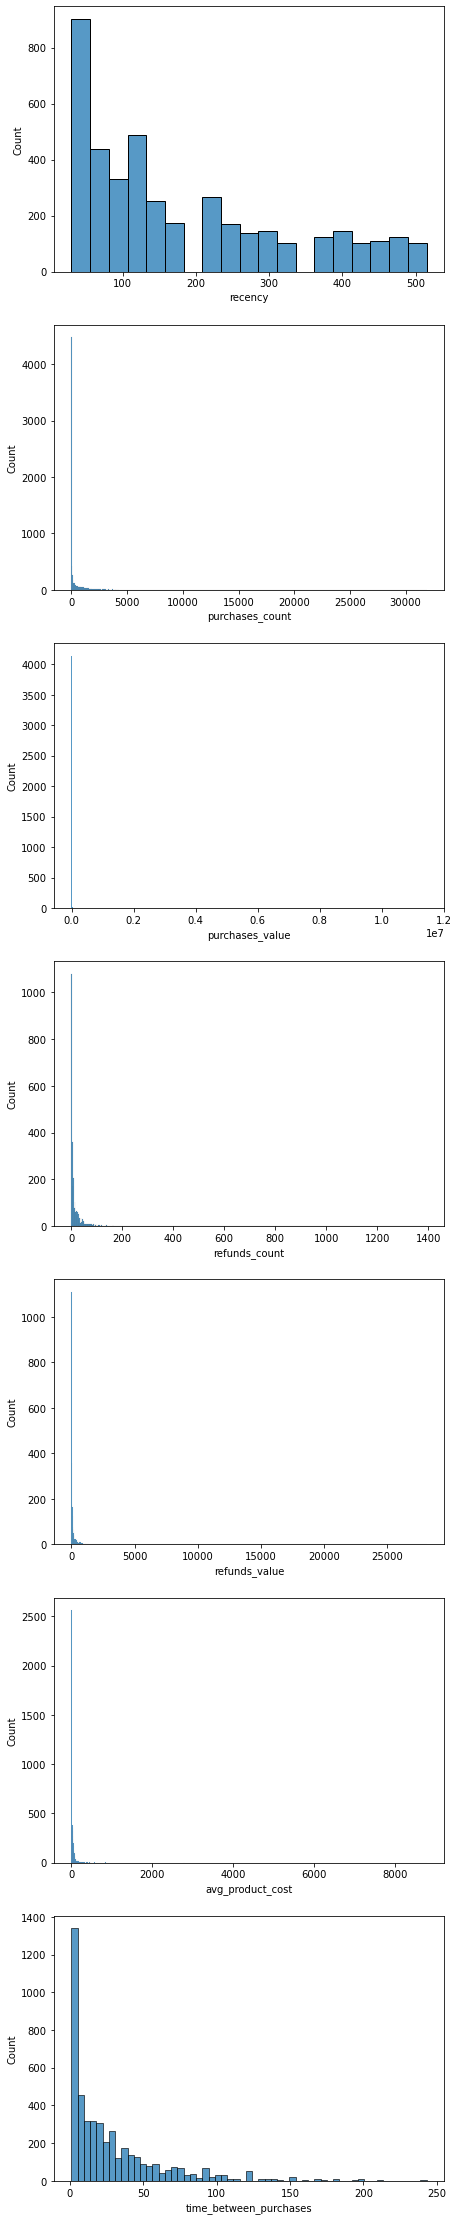

In [13]:
profile_variables: List[str] = rfm_table.columns.drop('cac')

figure, axes = plt.subplots(len(profile_variables), 1, figsize = (7, 40))
for i, variable in enumerate(profile_variables):
    sns.histplot(data= rfm_table[rfm_table[variable] != 0], x= variable, ax = axes[i])

Although not easy to perceive due to outliers and high leverage points, the variables' distribution are not normal, being heavily skewed. The following table helps to shed light on this fact:


-- recency --


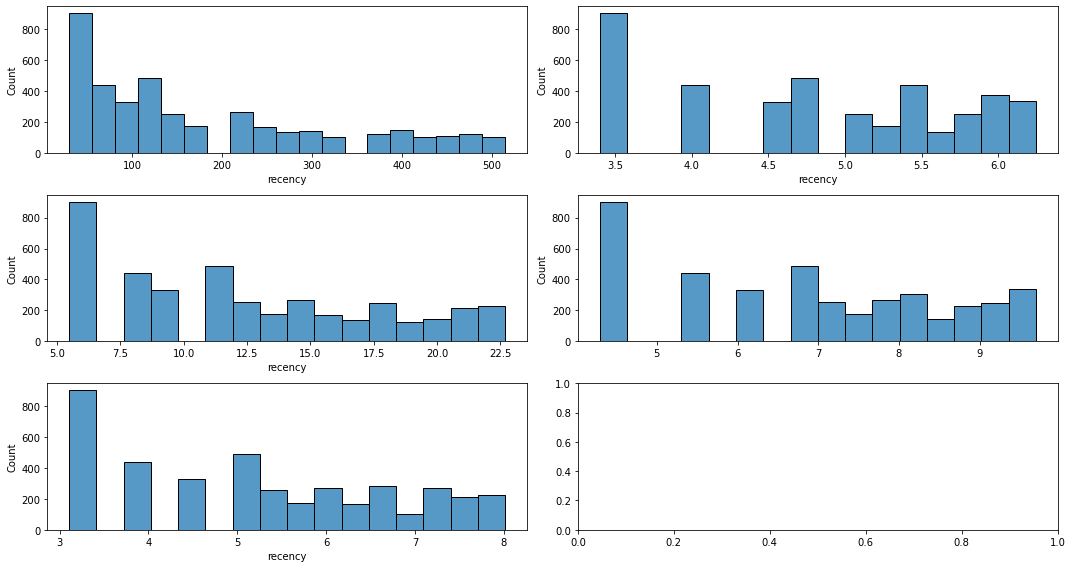

         Model  Skewness
0         None      0.84
1          Log     -0.19
2  Square Root      0.35
3      Box-Cox     -0.05
4   Cubic Root      0.17
-- purchases_count --


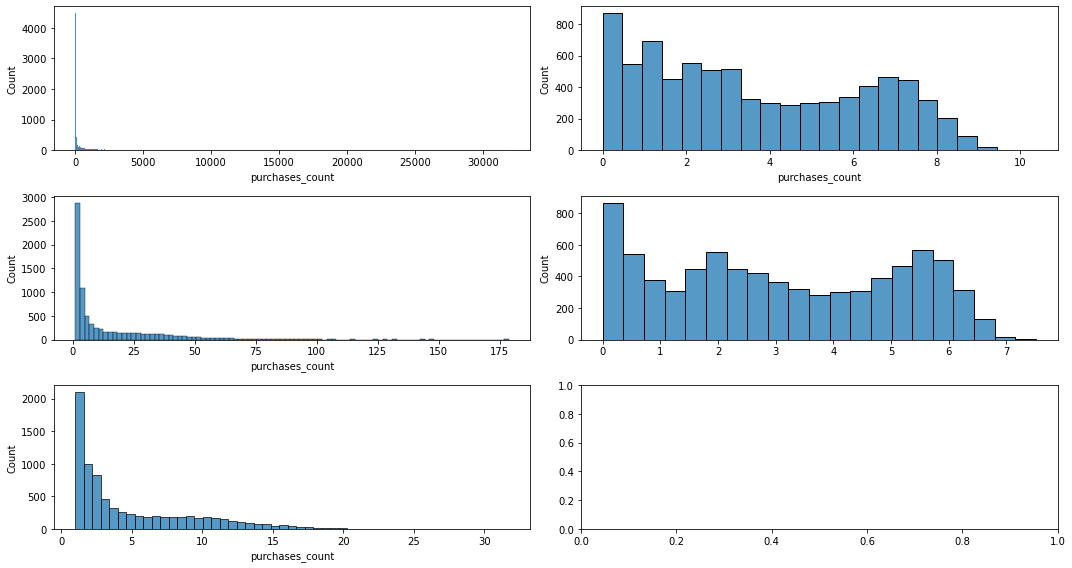

         Model  Skewness
0         None      6.69
1          Log      0.26
2  Square Root      1.97
3      Box-Cox      0.07
4   Cubic Root      1.29
-- purchases_value --


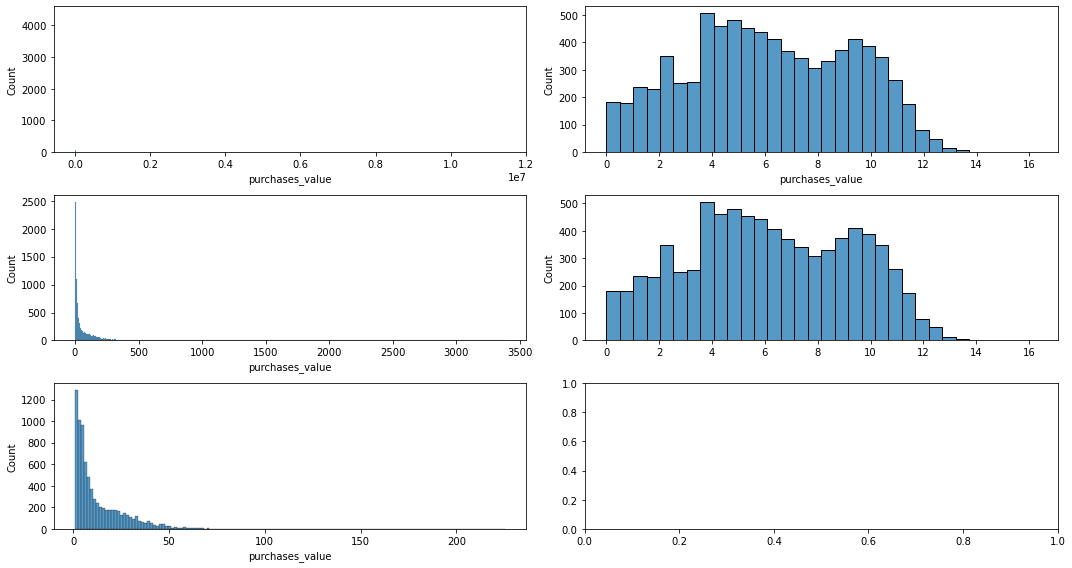

         Model  Skewness
0         None     71.42
1          Log     -0.00
2  Square Root      7.10
3      Box-Cox     -0.00
4   Cubic Root      2.23
-- refunds_count --


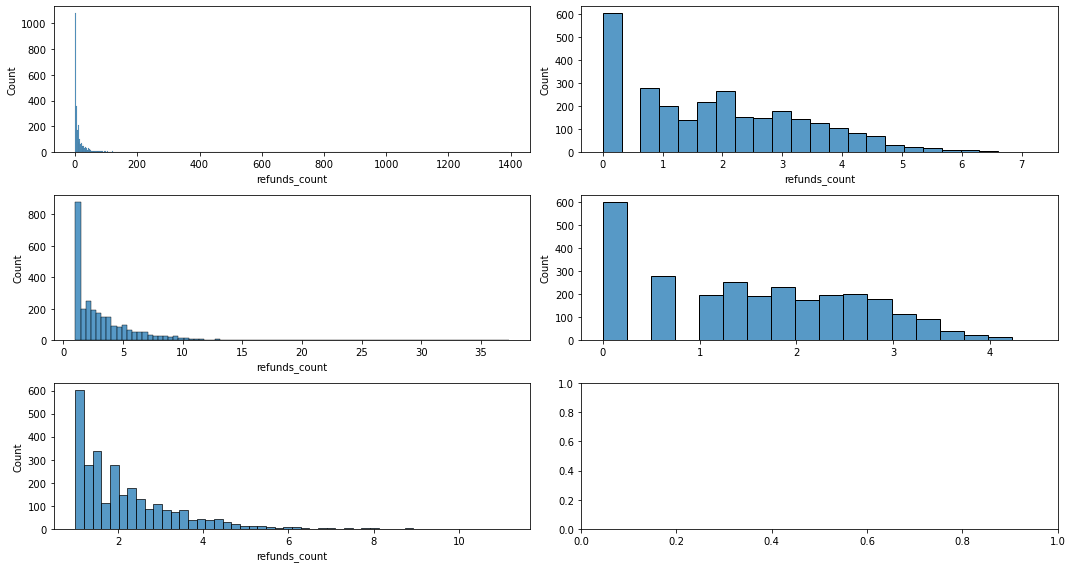

         Model  Skewness
0         None      9.54
1          Log      0.43
2  Square Root      2.87
3      Box-Cox      0.07
4   Cubic Root      1.74
-- refunds_value --


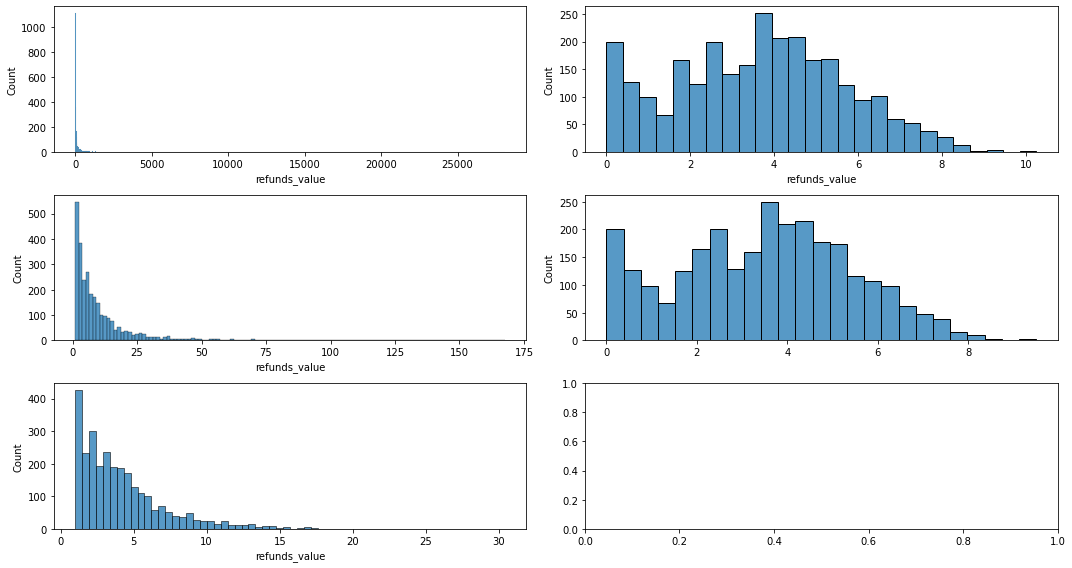

         Model  Skewness
0         None     14.85
1          Log      0.07
2  Square Root      3.58
3      Box-Cox      0.01
4   Cubic Root      1.96
-- avg_product_cost --


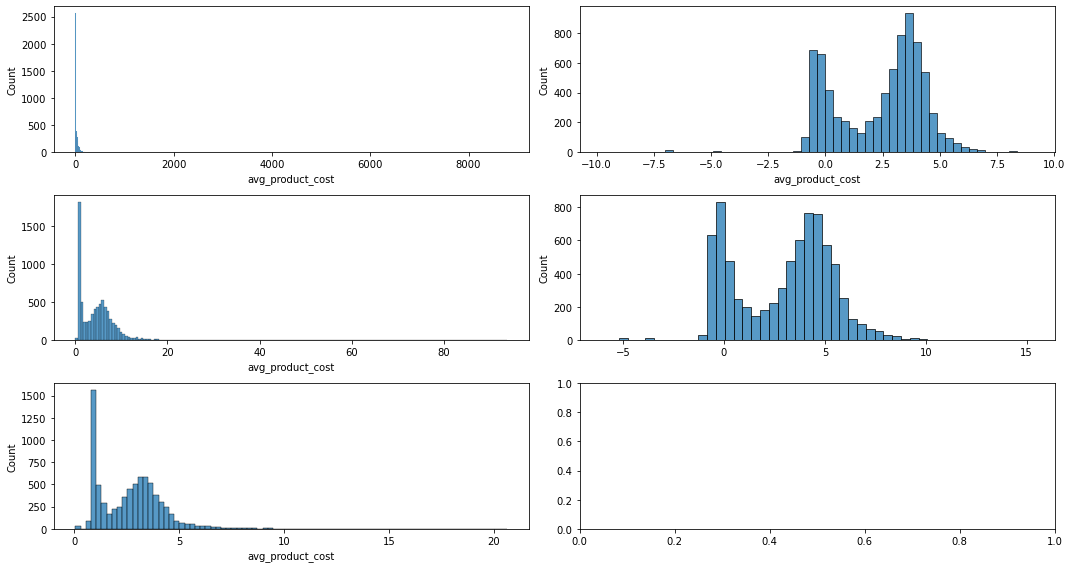

         Model  Skewness
0         None     28.34
1          Log     -0.53
2  Square Root      5.23
3      Box-Cox     -0.03
4   Cubic Root      1.65
-- time_between_purchases --


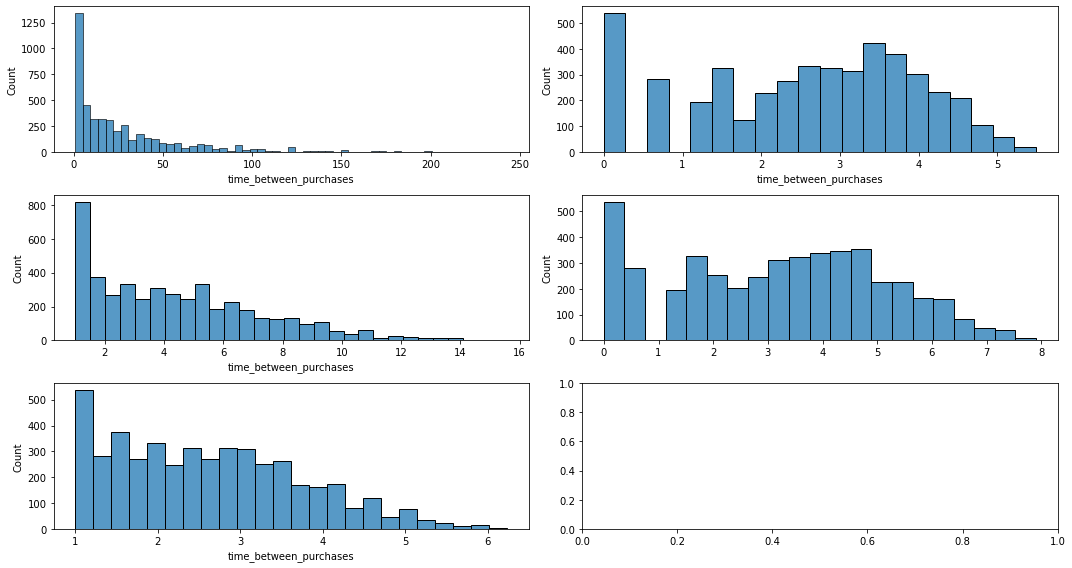

         Model  Skewness
0         None      2.12
1          Log     -0.33
2  Square Root      0.83
3      Box-Cox     -0.06
4   Cubic Root      0.42


In [11]:
for var in profile_variables:
    analyze_skewness(var)

While none of the transformations produced a quasi-normal distribution, several managed to drastically reduce the skewness close to 0. These transformations will be maintained:
* recency - box-cox
* purchases_count - box-cox
* purchases_value - box-cox
* reunds_count - box-cox
* refunds_value - box-cox
* avg_product_cost - box-cox
* time_between_purchases - box-cox

In [14]:
#box-cox transformation
cluster_data: pd.DataFrame = rfm_table.copy()
    
for var in profile_variables:
    cluster_data.loc[cluster_data[var] > 0, var] = stats.boxcox(cluster_data.loc[cluster_data[var] > 0, var])[0]

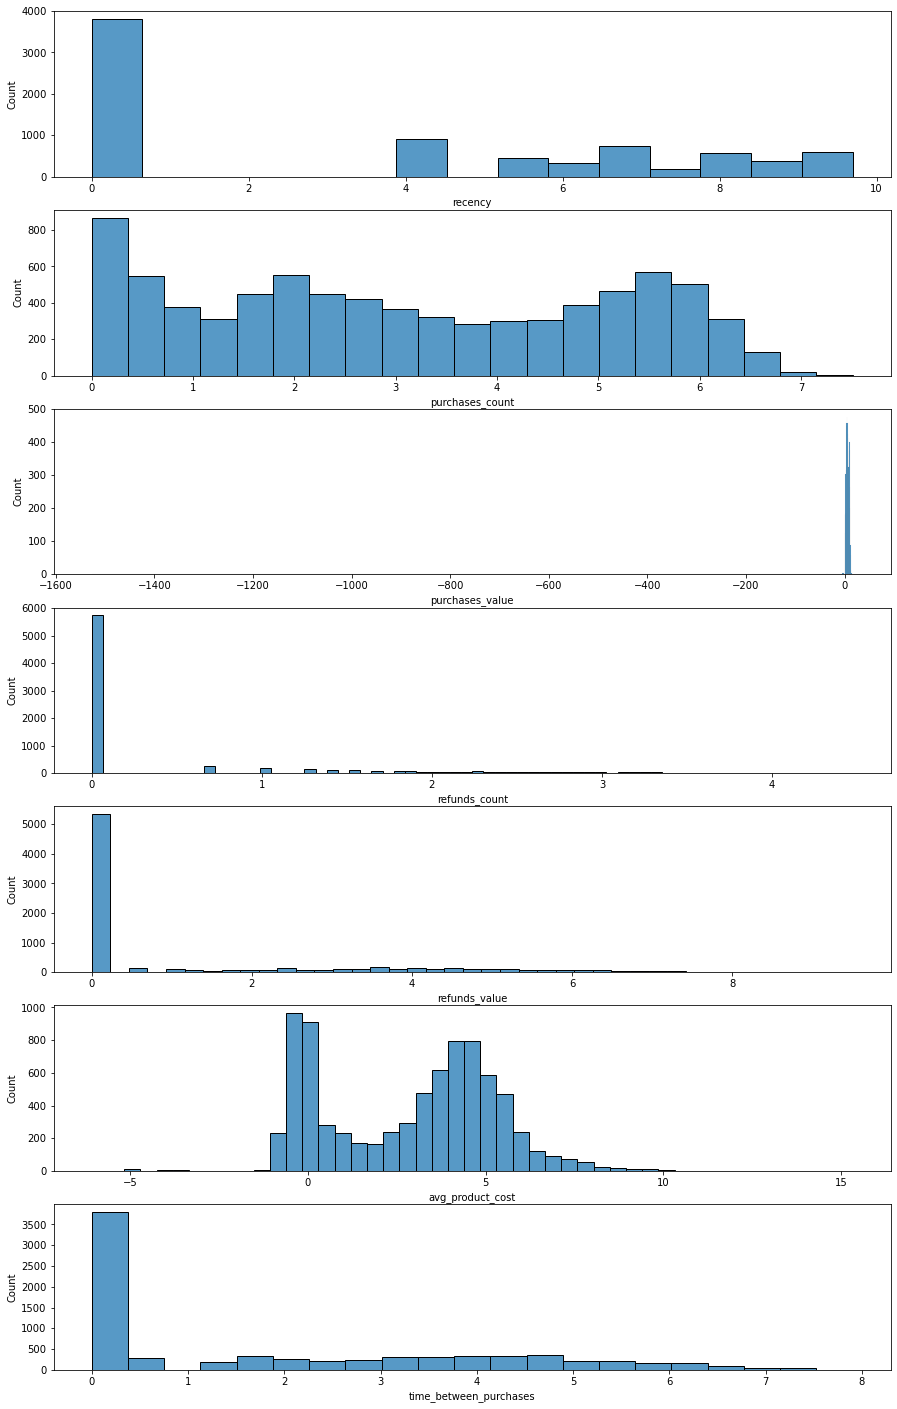

In [27]:
fig, axes = plt.subplots(len(profile_variables), 1, figsize=(15,25))

for i, var in enumerate(profile_variables):
    sns.histplot(cluster_data[var], ax = axes[i])

## Normalize Features

Whilst the skewness has been drastically reduced - and in some cases, removed - the variable's distribution is far from normal. This section attempts to transform each variable's distribution to make them as close to normality as possible, whilst also normalizing the distances computed by the clustering algorithm.

In [15]:
scaler = StandardScaler()

scaler.fit(cluster_data[profile_variables])
cluster_data: pd.DataFrame = scaler.transform(cluster_data[profile_variables])

print('Mean:', cluster_data.mean(axis= 0).round(2))
print('Std:', cluster_data.std(axis= 0).round(2))

Mean: [-0. -0. -0.  0. -0. -0.  0.]
Std: [1. 1. 1. 1. 1. 1. 1.]


In [29]:
pd.DataFrame(cluster_data).head(5)

0         1         2         3         4         5         6
0 -0.973217  0.570462  0.090227  0.118376  0.065998  0.643752 -0.322736
1 -0.973217  1.433722  0.130413  1.972579  1.188214  1.150720 -0.866194
2 -0.973217  1.548383  0.186404  0.118376  2.857307  0.692179 -0.866194
3  0.209294  0.585025  0.126590  1.501359  1.797921  0.107049 -0.322736
4 -0.973217 -0.991174 -0.022716 -0.549781 -0.607648 -1.281820 -0.866194

# Clustering

## Feature Selection

### Feature Selection using Random Forest

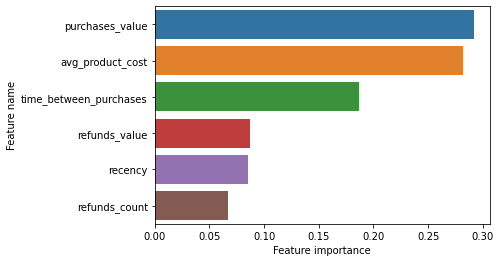

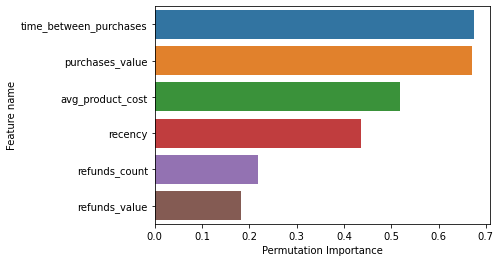

In [16]:
x = rfm_table.drop(['cac', 'purchases_count'],axis = 1)
Y = rfm_table['purchases_count']

random_forest = RandomForestClassifier(n_estimators = 60,
                                        random_state = 30)

random_forest.fit(x, Y)

plot_feature_importance(random_forest)
plot_permutation_importance(random_forest, x, Y)

# We wont run SHAP as it takes a few hours to go through the data
#plot_shap_importance(random_forest, x)

The random forest model considered most features relevant with the exception of refund-related features. However, we know these are important to flag potentially disastisfied customers, hence the model's results are inconclusive.

### Feature Selection and Clustering using K-Means

The feature and cluster selection will be performed using k-Means' evaluation metrics: sum of squared error minimization and silhouette score maximization

Computing for features: recency


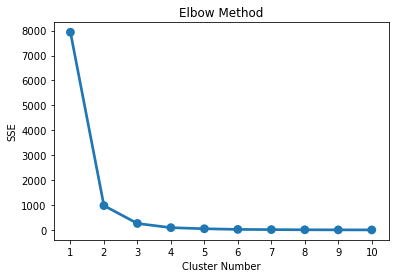

Computing for features: purchases_count


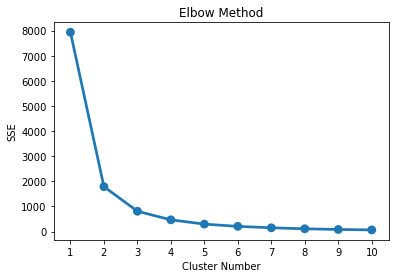

Computing for features: purchases_value


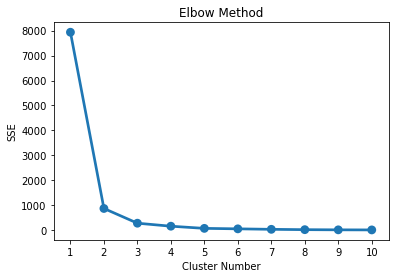

Computing for features: refunds_count


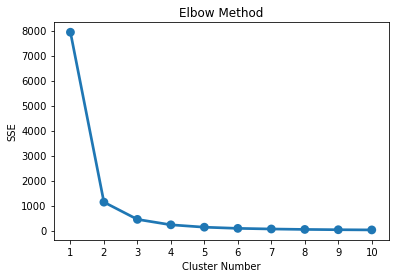

Computing for features: refunds_value


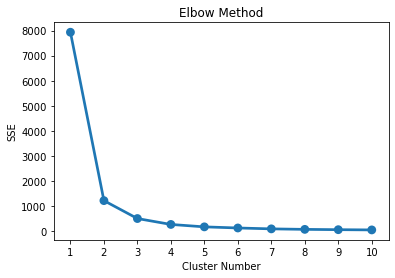

Computing for features: avg_product_cost


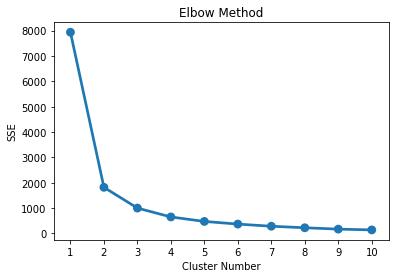

Computing for features: time_between_purchases


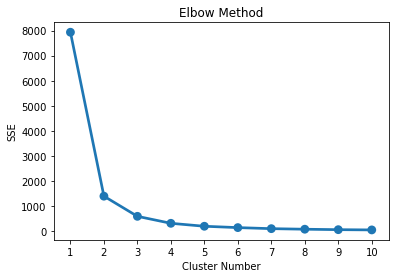

Computing for features: ('recency', 'purchases_count')


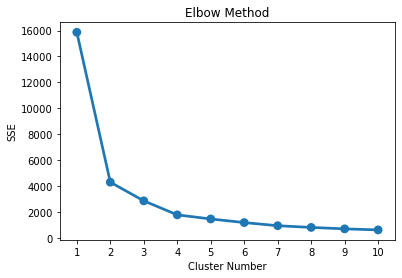

Computing for features: ('recency', 'purchases_value')


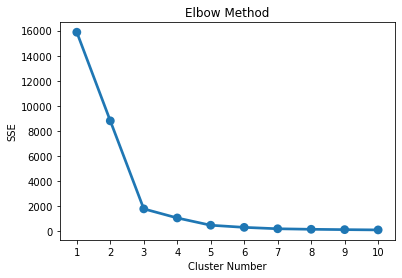

Computing for features: ('recency', 'refunds_count')


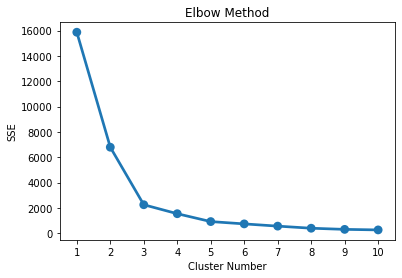

Computing for features: ('recency', 'refunds_value')


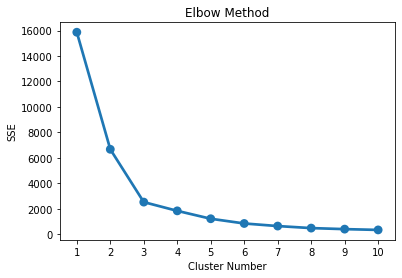

Computing for features: ('recency', 'avg_product_cost')


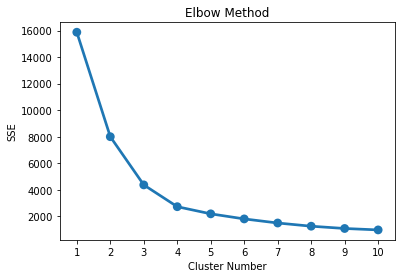

Computing for features: ('recency', 'time_between_purchases')


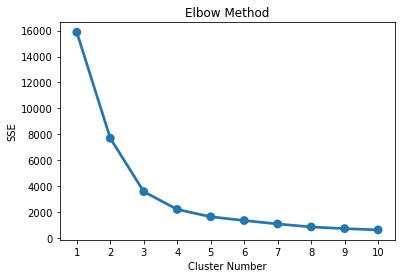

Computing for features: ('purchases_count', 'purchases_value')


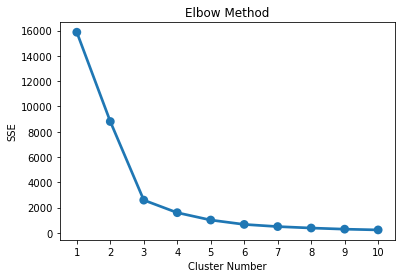

Computing for features: ('purchases_count', 'refunds_count')


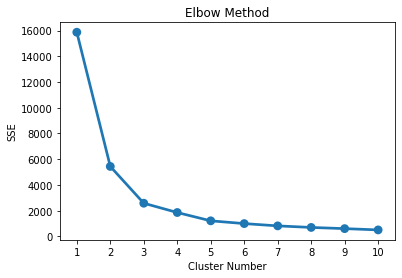

Computing for features: ('purchases_count', 'refunds_value')


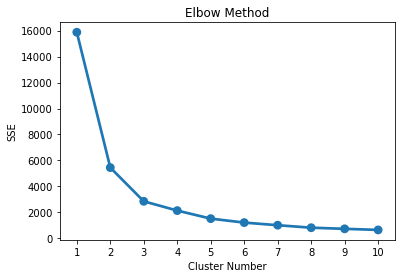

Computing for features: ('purchases_count', 'avg_product_cost')


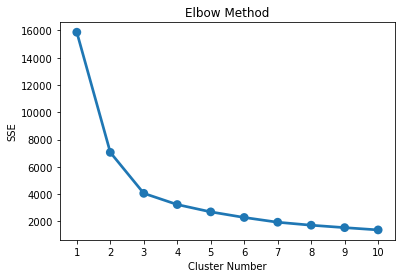

Computing for features: ('purchases_count', 'time_between_purchases')


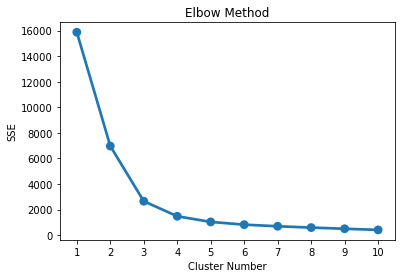

Computing for features: ('purchases_value', 'refunds_count')


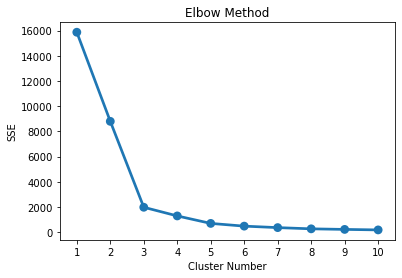

Computing for features: ('purchases_value', 'refunds_value')


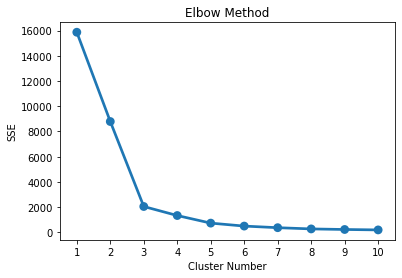

Computing for features: ('purchases_value', 'avg_product_cost')


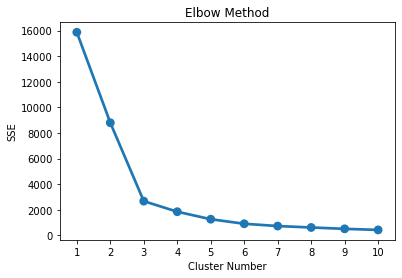

Computing for features: ('purchases_value', 'time_between_purchases')


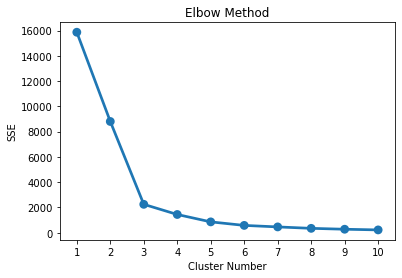

Computing for features: ('refunds_count', 'refunds_value')


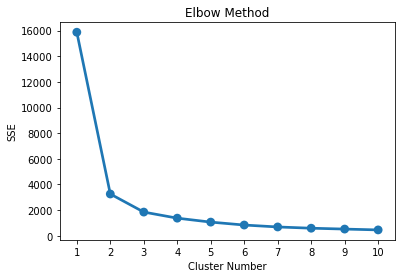

Computing for features: ('refunds_count', 'avg_product_cost')


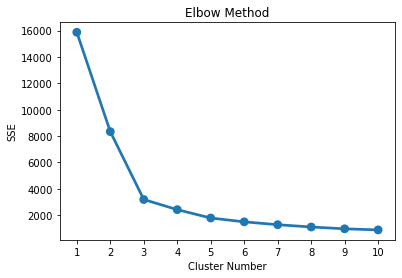

Computing for features: ('refunds_count', 'time_between_purchases')


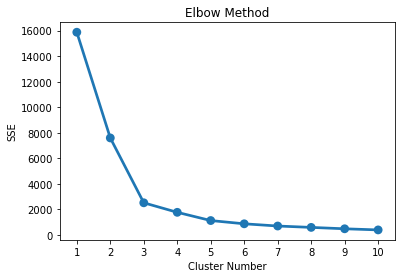

Computing for features: ('refunds_value', 'avg_product_cost')


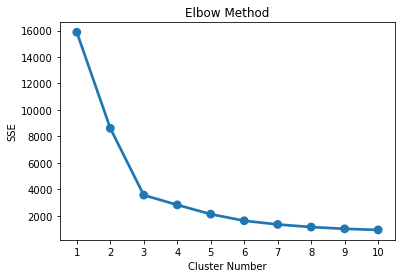

Computing for features: ('refunds_value', 'time_between_purchases')


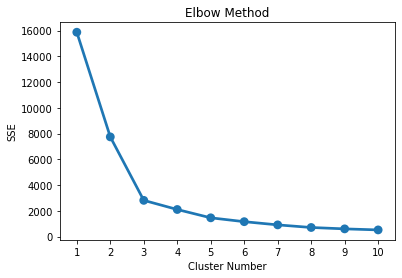

Computing for features: ('avg_product_cost', 'time_between_purchases')


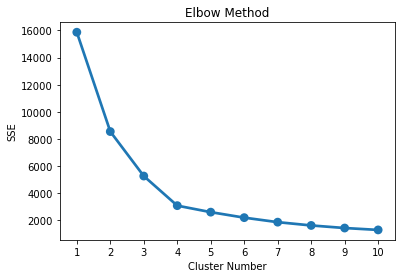

Computing for features: ('recency', 'purchases_count', 'purchases_value')


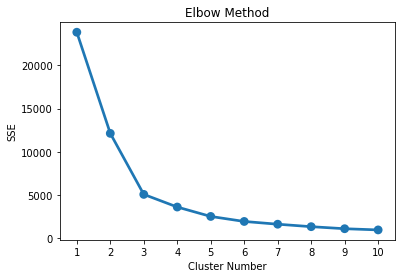

Computing for features: ('recency', 'purchases_count', 'refunds_count')


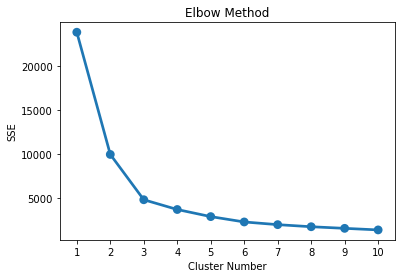

Computing for features: ('recency', 'purchases_count', 'refunds_value')


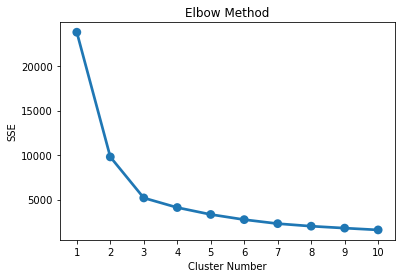

Computing for features: ('recency', 'purchases_count', 'avg_product_cost')


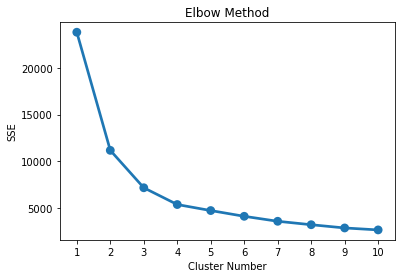

Computing for features: ('recency', 'purchases_count', 'time_between_purchases')


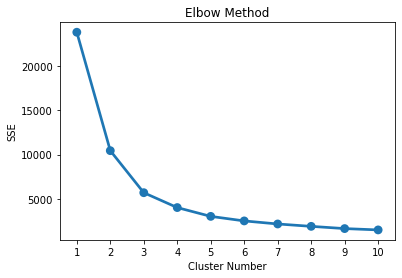

Computing for features: ('recency', 'purchases_value', 'refunds_count')


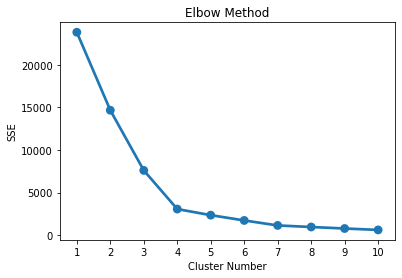

Computing for features: ('recency', 'purchases_value', 'refunds_value')


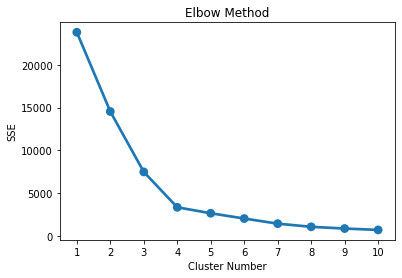

Computing for features: ('recency', 'purchases_value', 'avg_product_cost')


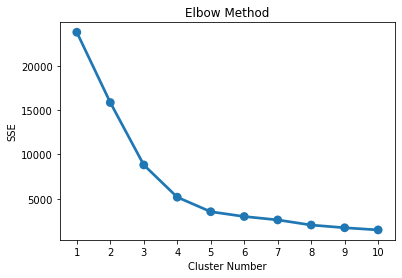

Computing for features: ('recency', 'purchases_value', 'time_between_purchases')


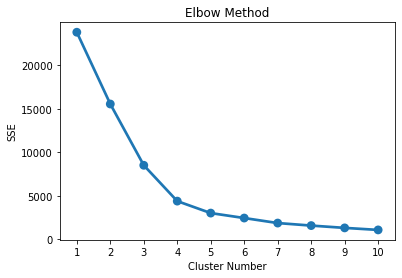

Computing for features: ('recency', 'refunds_count', 'refunds_value')


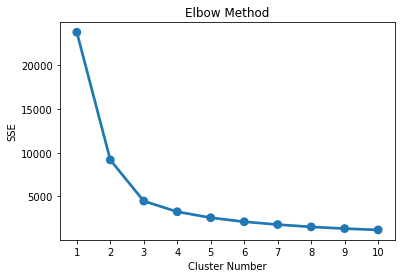

Computing for features: ('recency', 'refunds_count', 'avg_product_cost')


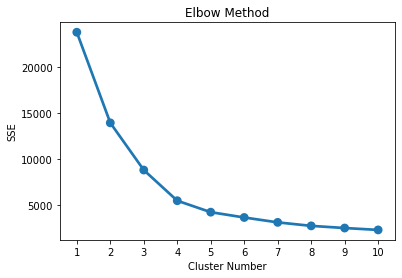

Computing for features: ('recency', 'refunds_count', 'time_between_purchases')


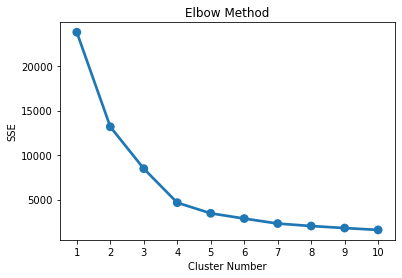

Computing for features: ('recency', 'refunds_value', 'avg_product_cost')


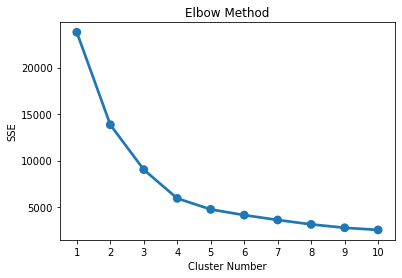

Computing for features: ('recency', 'refunds_value', 'time_between_purchases')


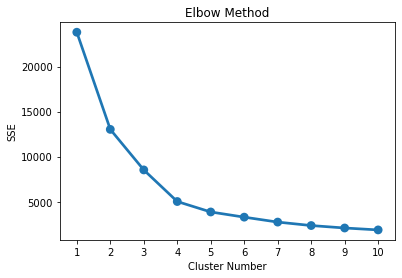

Computing for features: ('recency', 'avg_product_cost', 'time_between_purchases')


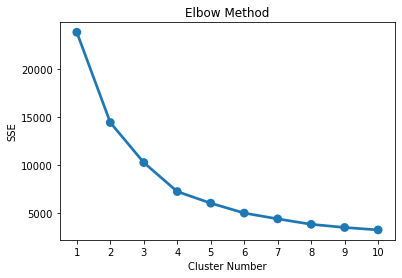

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count')


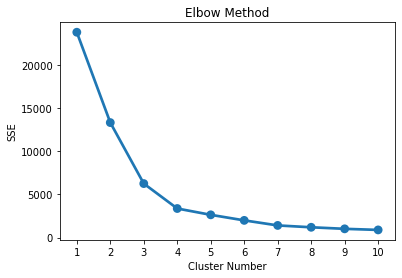

Computing for features: ('purchases_count', 'purchases_value', 'refunds_value')


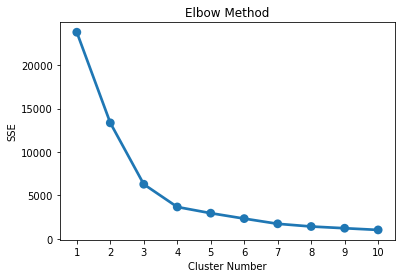

Computing for features: ('purchases_count', 'purchases_value', 'avg_product_cost')


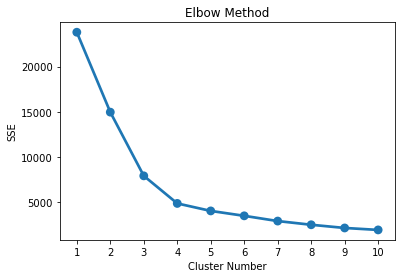

Computing for features: ('purchases_count', 'purchases_value', 'time_between_purchases')


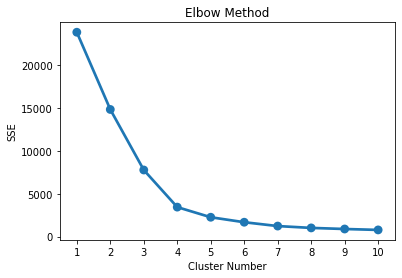

Computing for features: ('purchases_count', 'refunds_count', 'refunds_value')


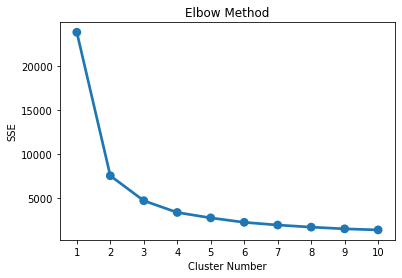

Computing for features: ('purchases_count', 'refunds_count', 'avg_product_cost')


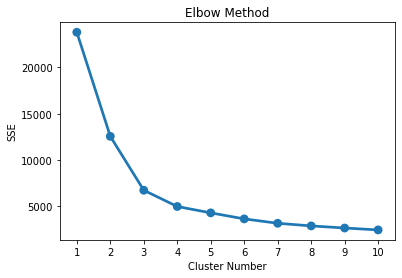

Computing for features: ('purchases_count', 'refunds_count', 'time_between_purchases')


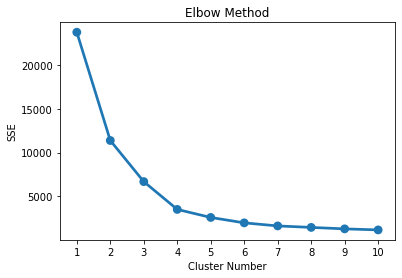

Computing for features: ('purchases_count', 'refunds_value', 'avg_product_cost')


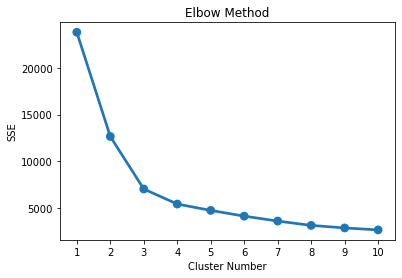

Computing for features: ('purchases_count', 'refunds_value', 'time_between_purchases')


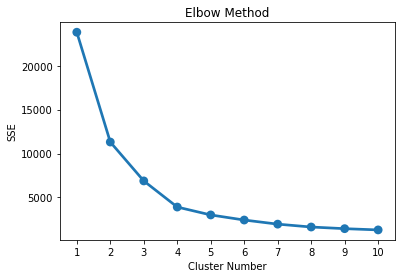

Computing for features: ('purchases_count', 'avg_product_cost', 'time_between_purchases')


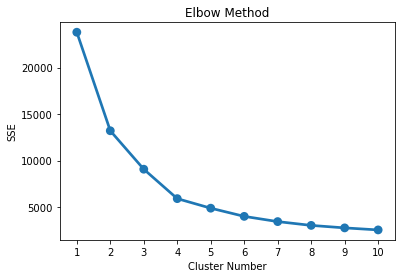

Computing for features: ('purchases_value', 'refunds_count', 'refunds_value')


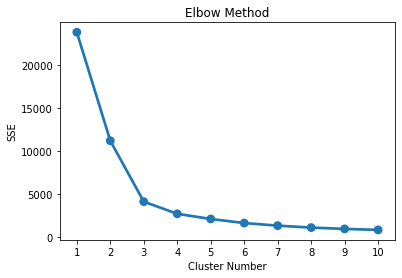

Computing for features: ('purchases_value', 'refunds_count', 'avg_product_cost')


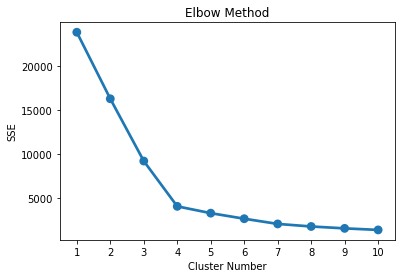

Computing for features: ('purchases_value', 'refunds_count', 'time_between_purchases')


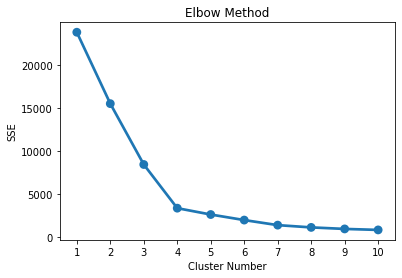

Computing for features: ('purchases_value', 'refunds_value', 'avg_product_cost')


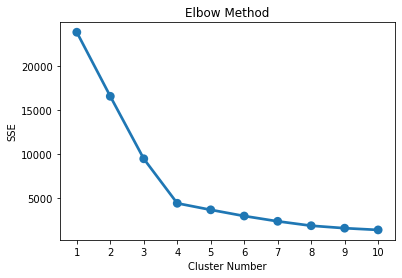

Computing for features: ('purchases_value', 'refunds_value', 'time_between_purchases')


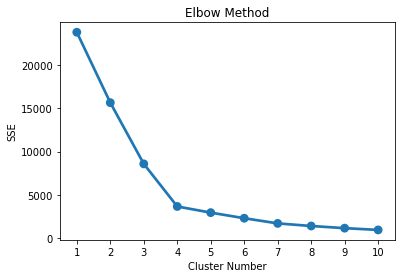

Computing for features: ('purchases_value', 'avg_product_cost', 'time_between_purchases')


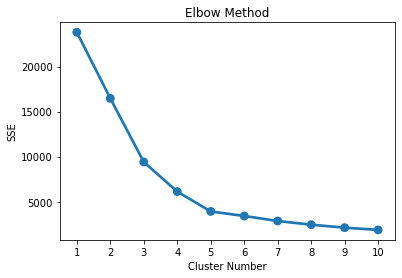

Computing for features: ('refunds_count', 'refunds_value', 'avg_product_cost')


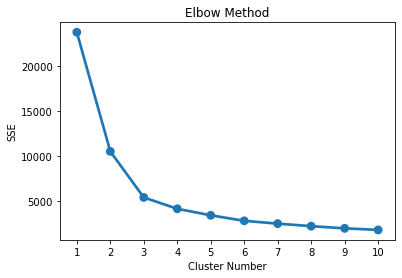

Computing for features: ('refunds_count', 'refunds_value', 'time_between_purchases')


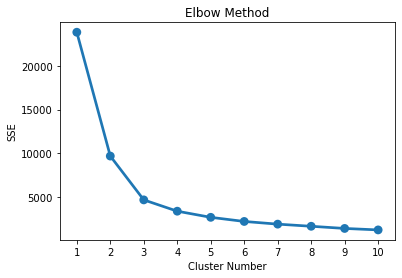

Computing for features: ('refunds_count', 'avg_product_cost', 'time_between_purchases')


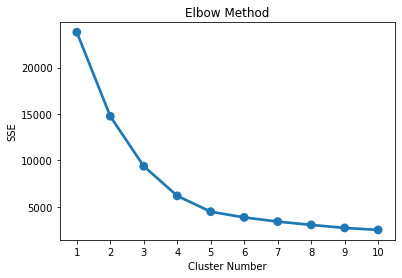

Computing for features: ('refunds_value', 'avg_product_cost', 'time_between_purchases')


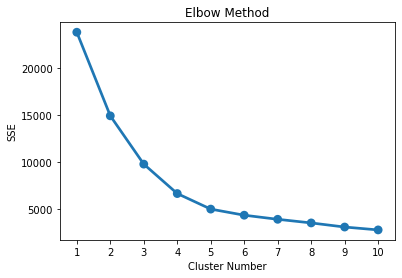

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count')


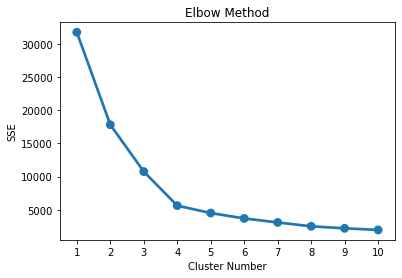

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_value')


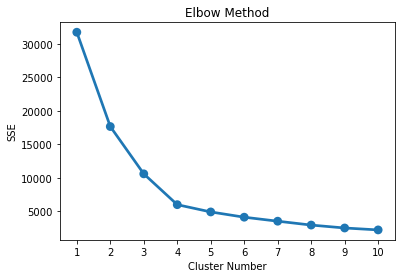

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'avg_product_cost')


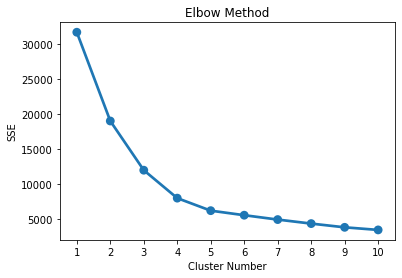

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'time_between_purchases')


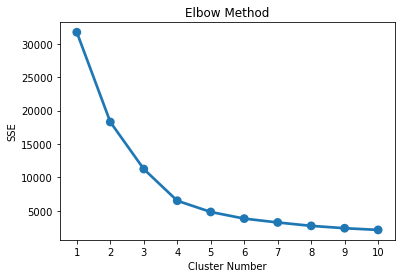

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'refunds_value')


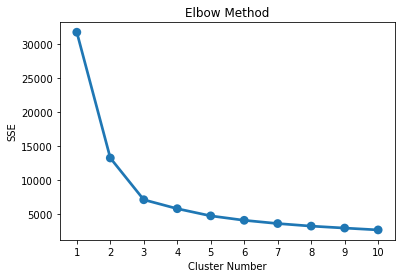

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'avg_product_cost')


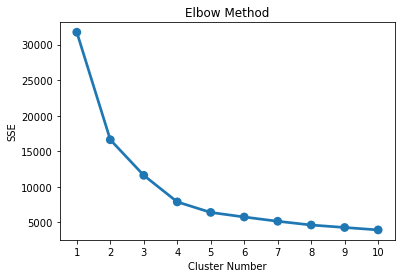

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'time_between_purchases')


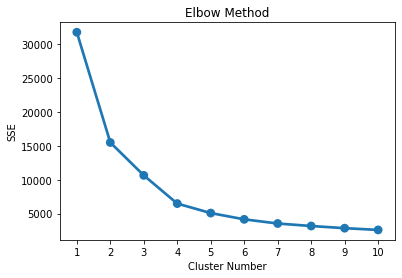

Computing for features: ('recency', 'purchases_count', 'refunds_value', 'avg_product_cost')


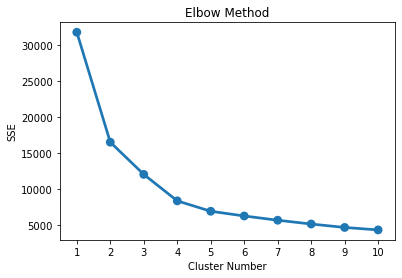

Computing for features: ('recency', 'purchases_count', 'refunds_value', 'time_between_purchases')


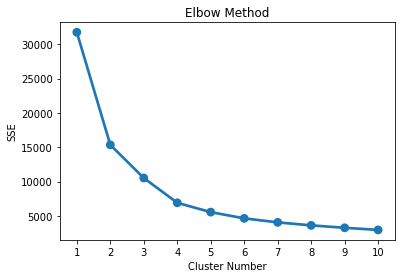

Computing for features: ('recency', 'purchases_count', 'avg_product_cost', 'time_between_purchases')


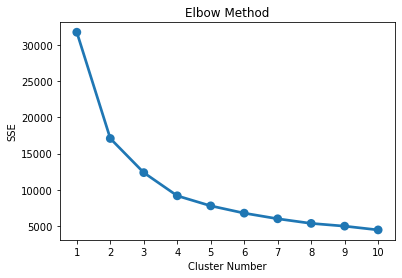

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'refunds_value')


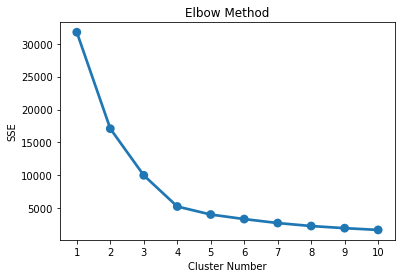

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'avg_product_cost')


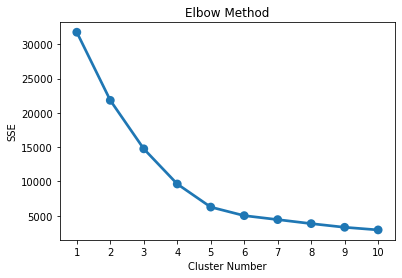

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'time_between_purchases')


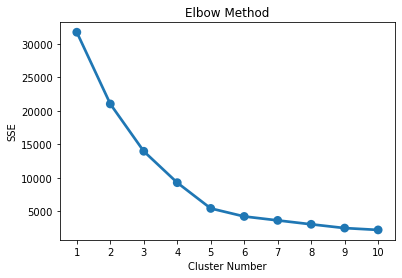

Computing for features: ('recency', 'purchases_value', 'refunds_value', 'avg_product_cost')


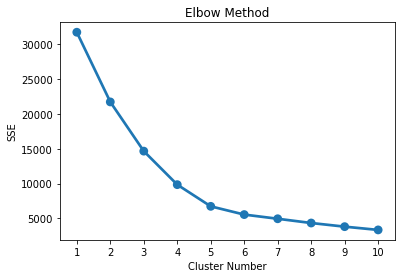

Computing for features: ('recency', 'purchases_value', 'refunds_value', 'time_between_purchases')


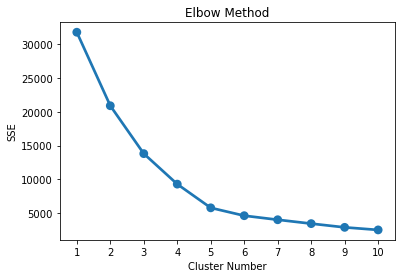

Computing for features: ('recency', 'purchases_value', 'avg_product_cost', 'time_between_purchases')


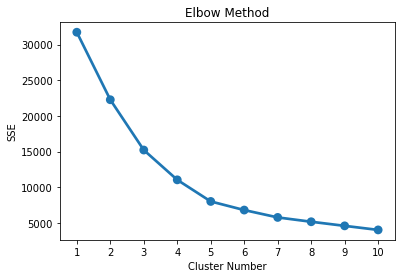

Computing for features: ('recency', 'refunds_count', 'refunds_value', 'avg_product_cost')


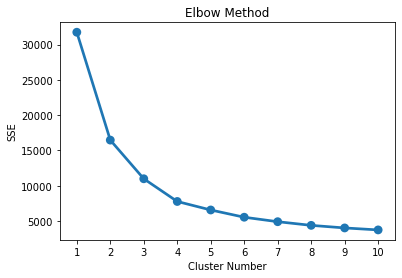

Computing for features: ('recency', 'refunds_count', 'refunds_value', 'time_between_purchases')


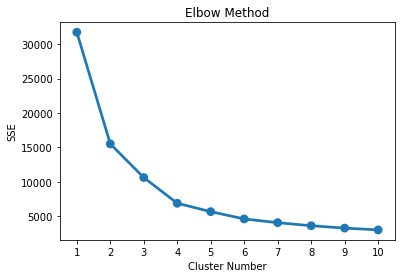

Computing for features: ('recency', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


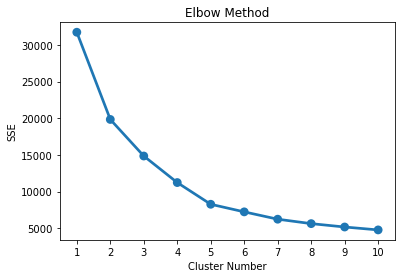

Computing for features: ('recency', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


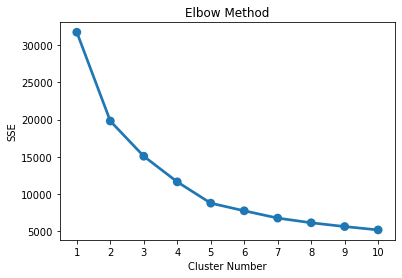

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'refunds_value')


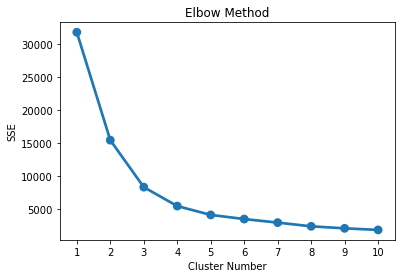

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'avg_product_cost')


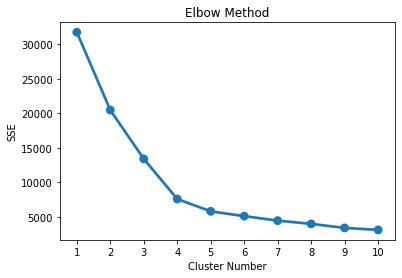

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'time_between_purchases')


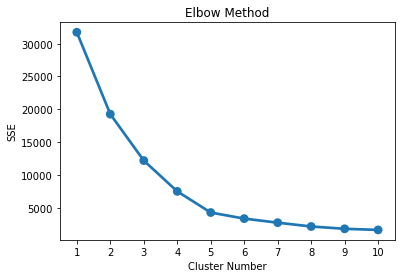

Computing for features: ('purchases_count', 'purchases_value', 'refunds_value', 'avg_product_cost')


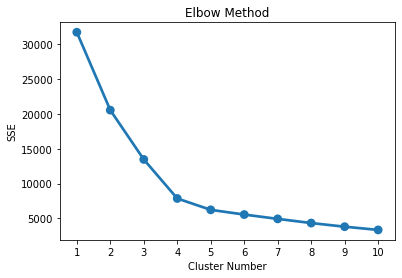

Computing for features: ('purchases_count', 'purchases_value', 'refunds_value', 'time_between_purchases')


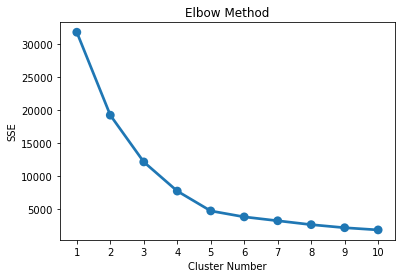

Computing for features: ('purchases_count', 'purchases_value', 'avg_product_cost', 'time_between_purchases')


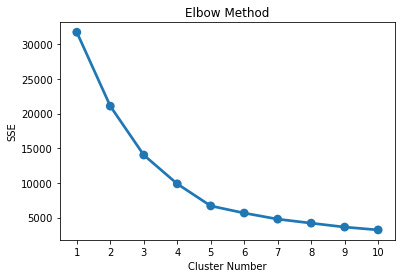

Computing for features: ('purchases_count', 'refunds_count', 'refunds_value', 'avg_product_cost')


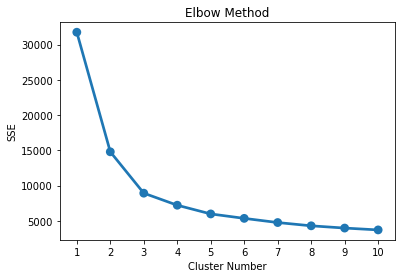

Computing for features: ('purchases_count', 'refunds_count', 'refunds_value', 'time_between_purchases')


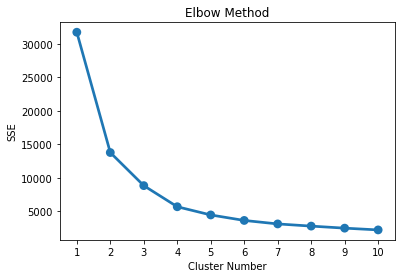

Computing for features: ('purchases_count', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


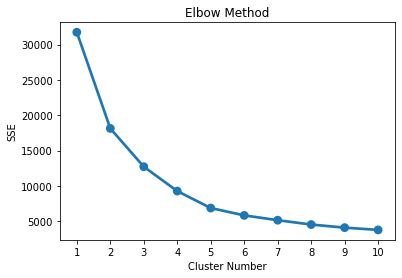

Computing for features: ('purchases_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


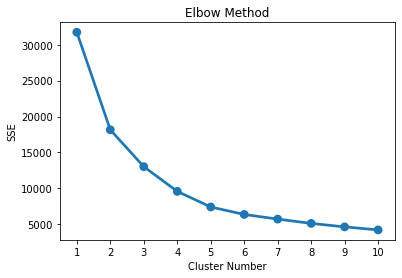

Computing for features: ('purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost')


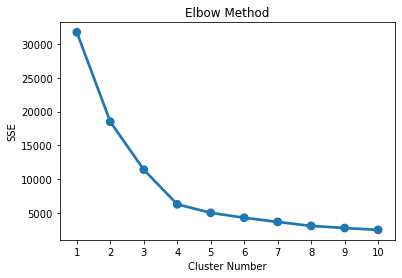

Computing for features: ('purchases_value', 'refunds_count', 'refunds_value', 'time_between_purchases')


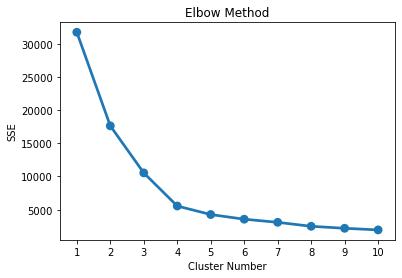

Computing for features: ('purchases_value', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


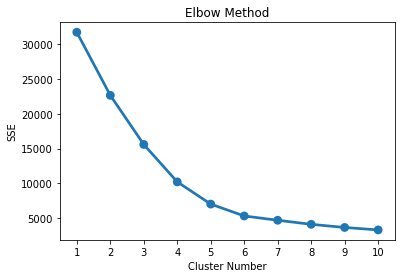

Computing for features: ('purchases_value', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


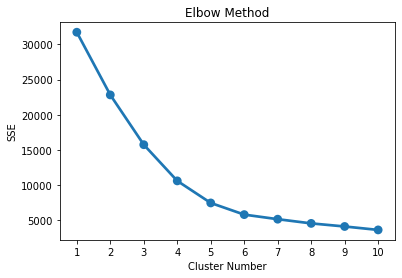

Computing for features: ('refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


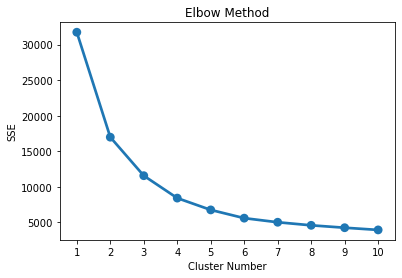

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'refunds_value')


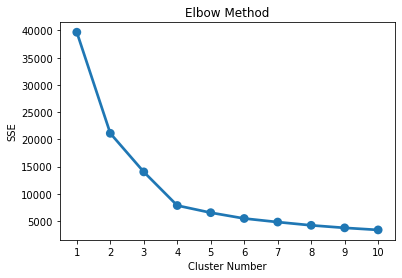

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'avg_product_cost')


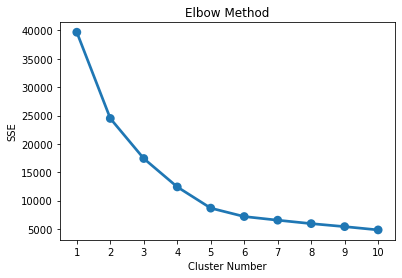

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'time_between_purchases')


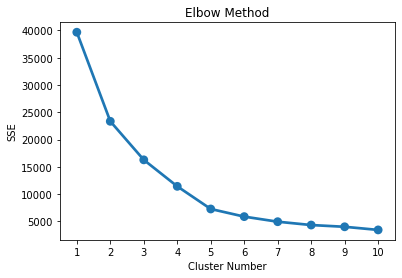

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_value', 'avg_product_cost')


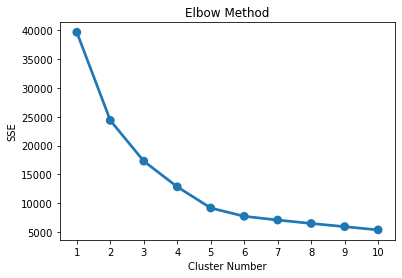

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_value', 'time_between_purchases')


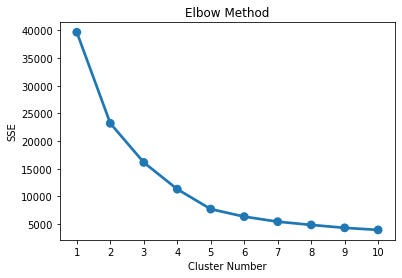

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'avg_product_cost', 'time_between_purchases')


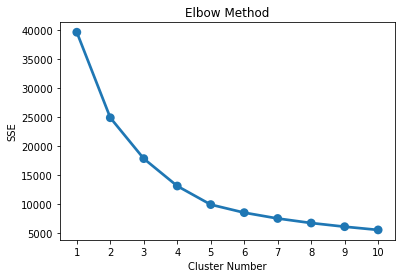

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'refunds_value', 'avg_product_cost')


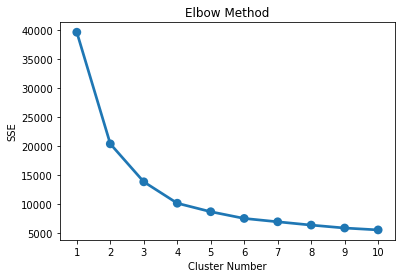

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'refunds_value', 'time_between_purchases')


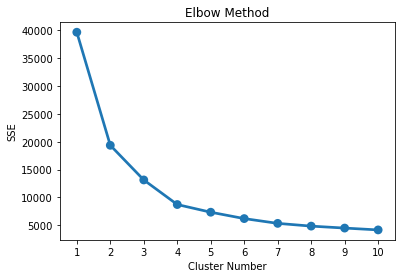

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


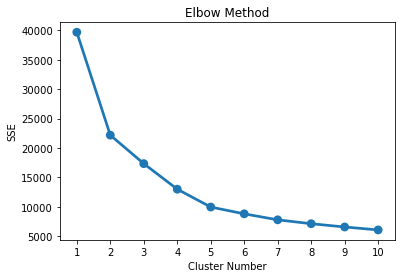

Computing for features: ('recency', 'purchases_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


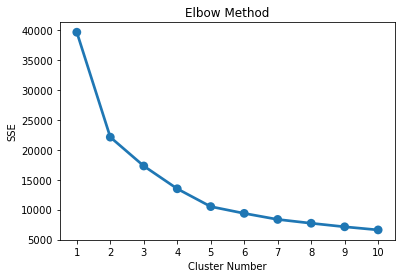

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost')


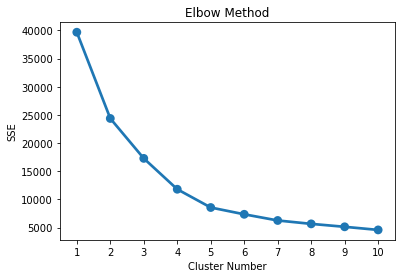

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'refunds_value', 'time_between_purchases')


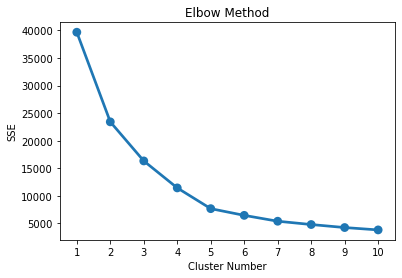

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


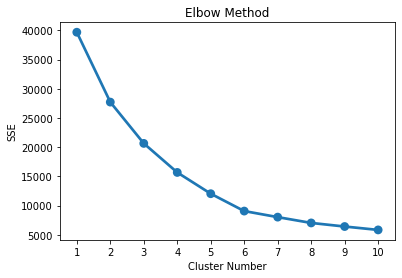

Computing for features: ('recency', 'purchases_value', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


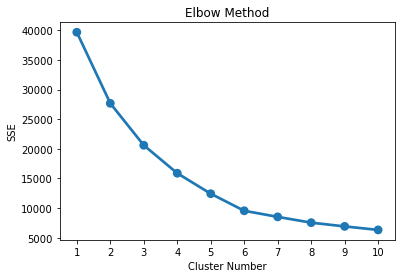

Computing for features: ('recency', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


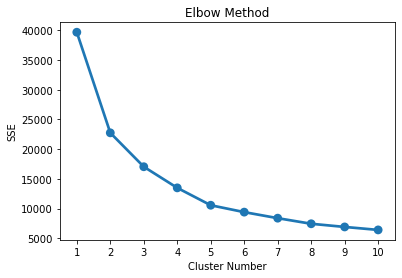

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost')


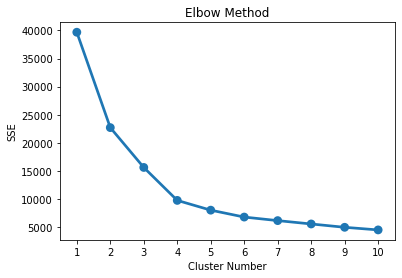

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'time_between_purchases')


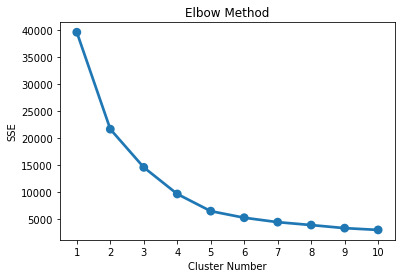

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


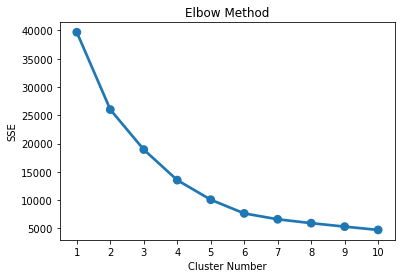

Computing for features: ('purchases_count', 'purchases_value', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


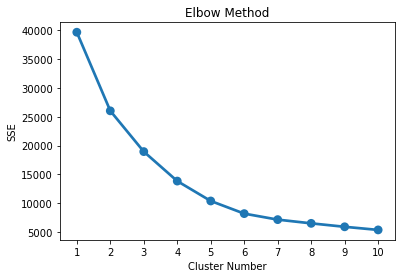

Computing for features: ('purchases_count', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


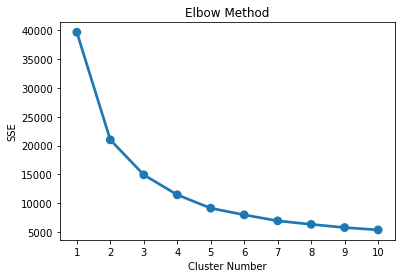

Computing for features: ('purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


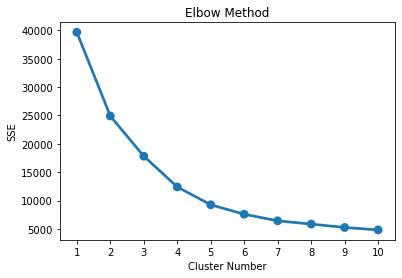

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost')


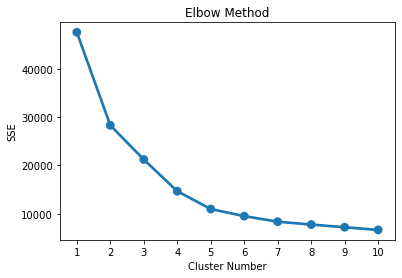

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'time_between_purchases')


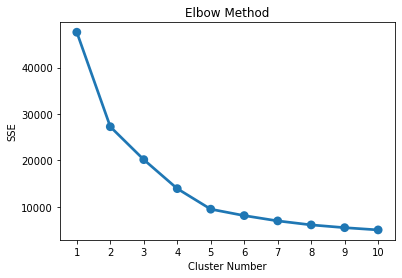

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'avg_product_cost', 'time_between_purchases')


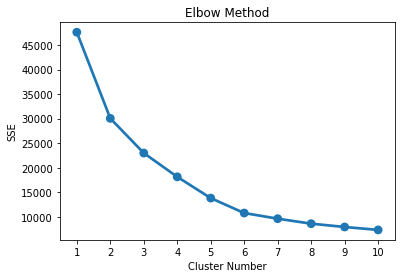

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


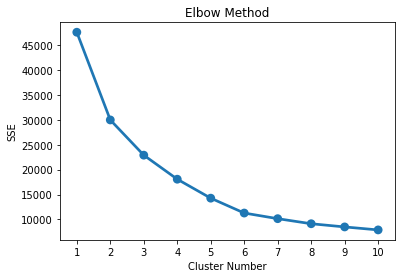

Computing for features: ('recency', 'purchases_count', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


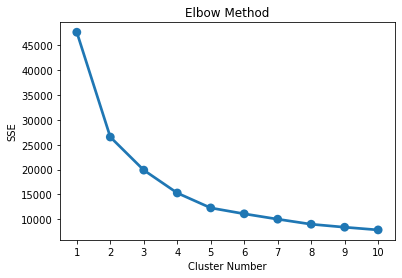

Computing for features: ('recency', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


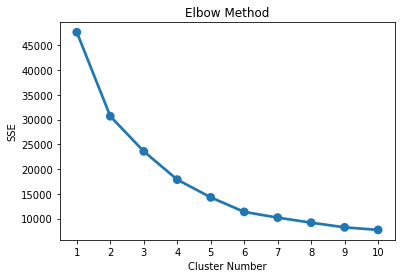

Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


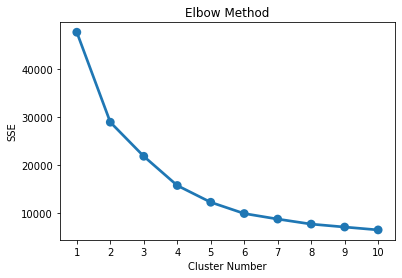

Computing for features: ('recency', 'purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost', 'time_between_purchases')


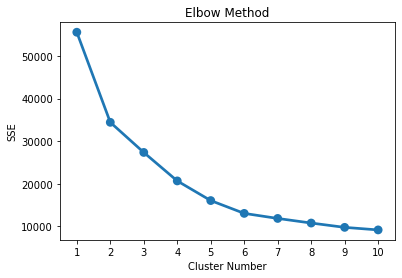

In [60]:
for subset in all_subsets(range(cluster_data.shape[1])):
    if len(subset) > 0:
        print('Computing for features:', itemgetter(*subset)(profile_variables))
        plot_elbow(cluster_data[:, subset])
        plt.show()

The previous plot, although extremely extensive, lets us perform feature selection without relying entirely on random forest.

The most complete combination which appears to yield the most well-behaved SSE curve to aid our decision, which yields the lowest SSE value before a small SSE decrease.

This appears to be the combination:
**`purchases_count`**
**`purchases_value`**
**`refunds_count`**
**`refunds_value`**
**`avg_product_cost`**


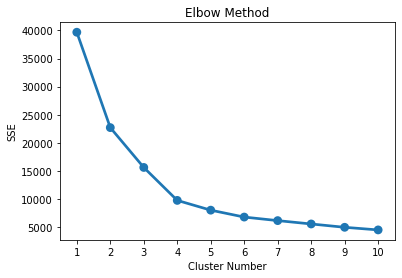

In [39]:
selected_features: List[str] = ['purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost']
variable_columns: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features))[0]
selected_data = cluster_data[:, variable_columns]

plot_elbow(selected_data)

### Evaluation - Silhouette Plot - All Features

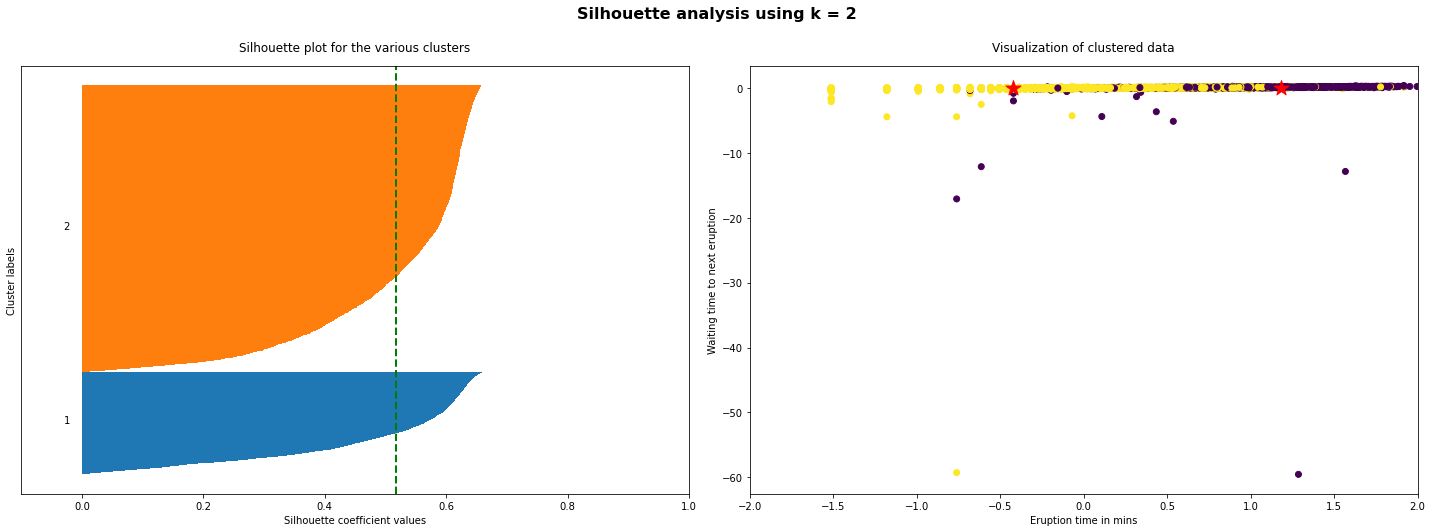

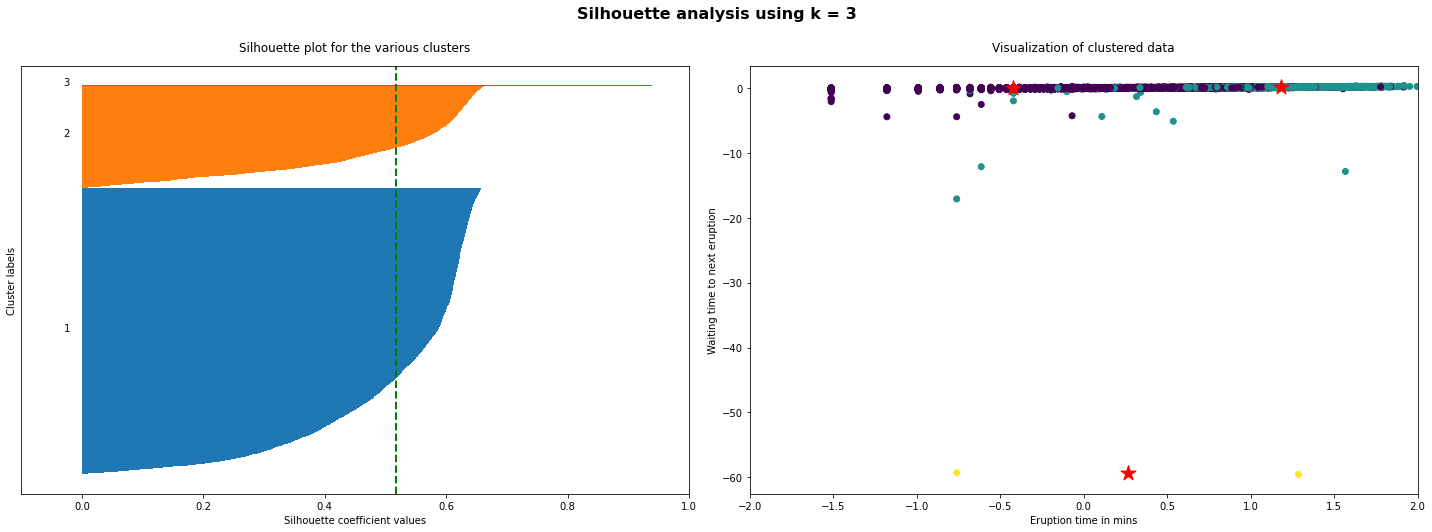

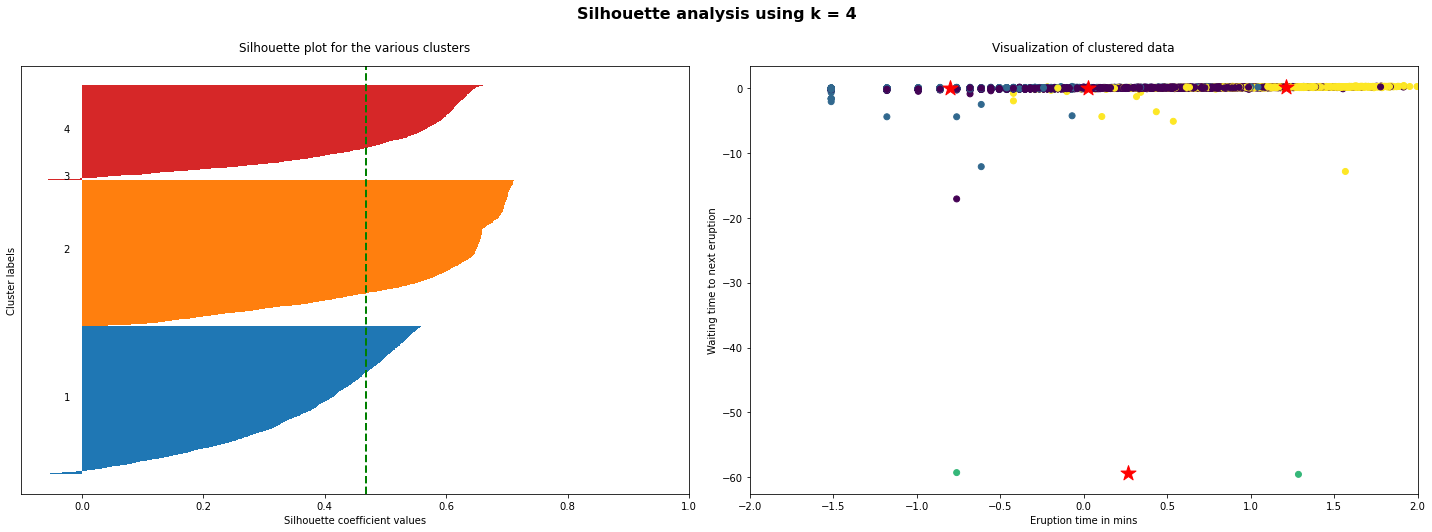

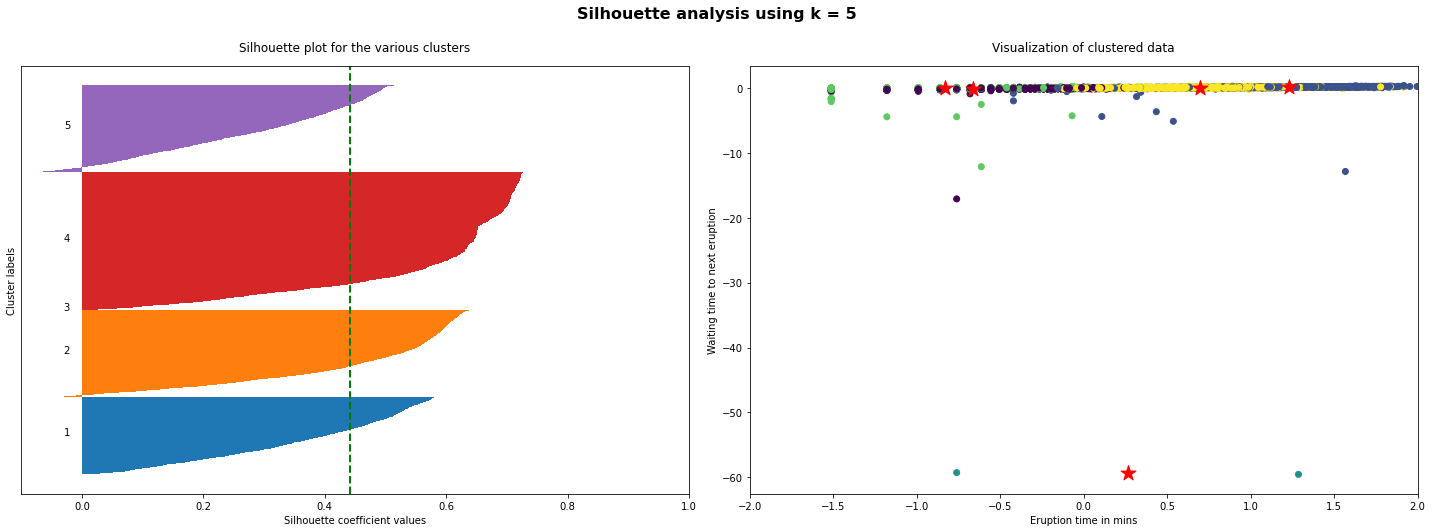

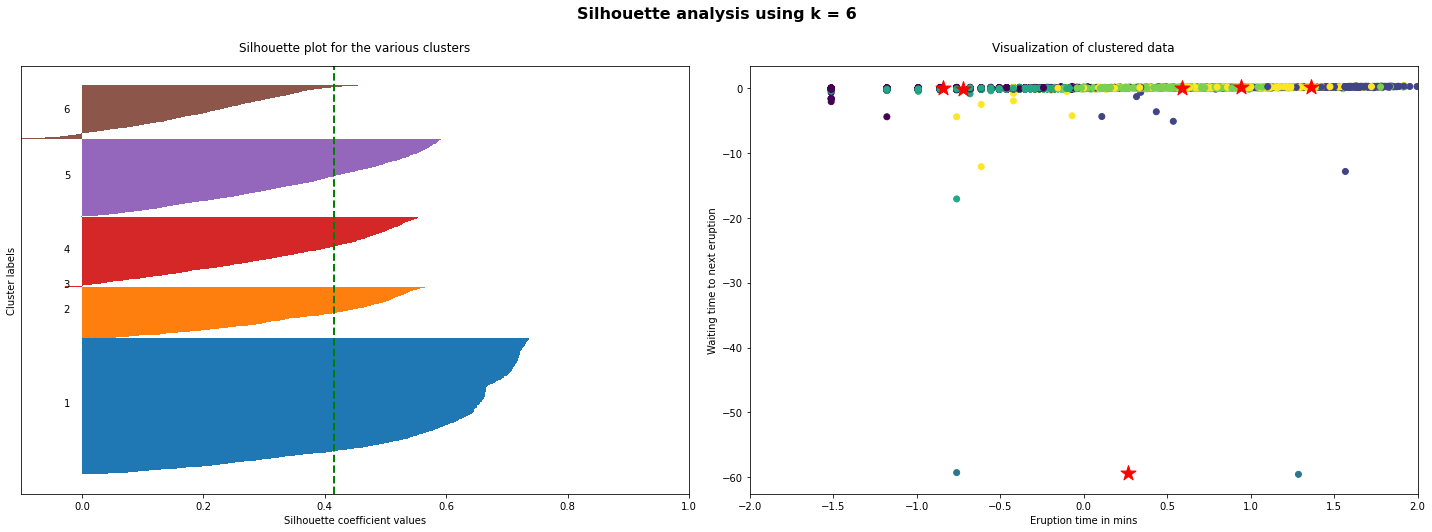

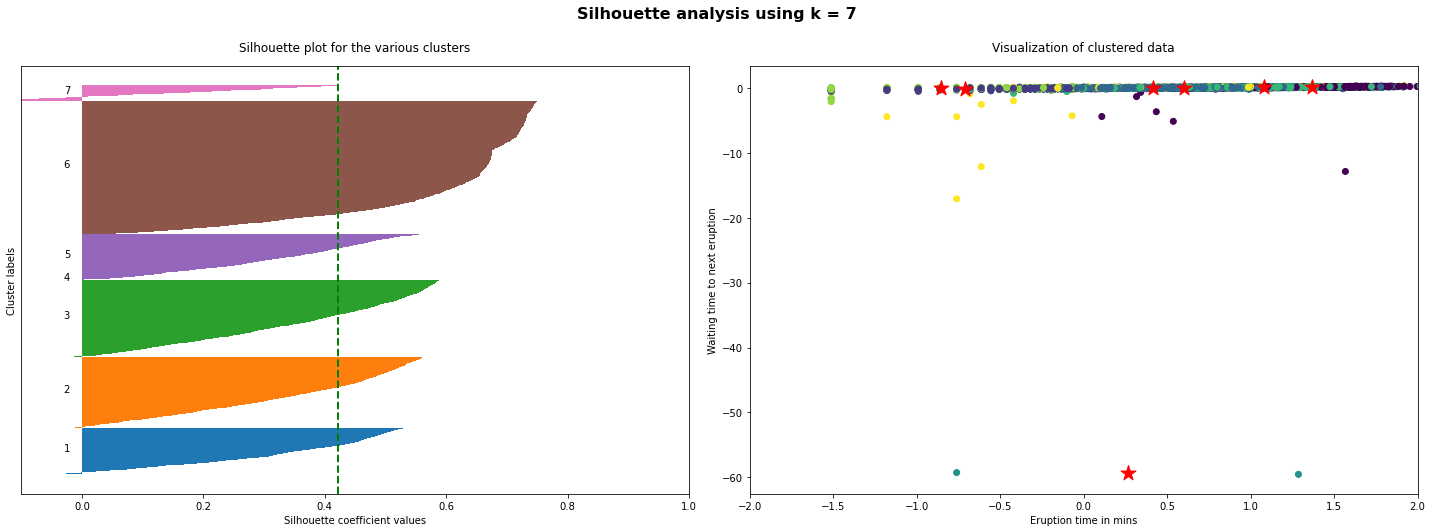

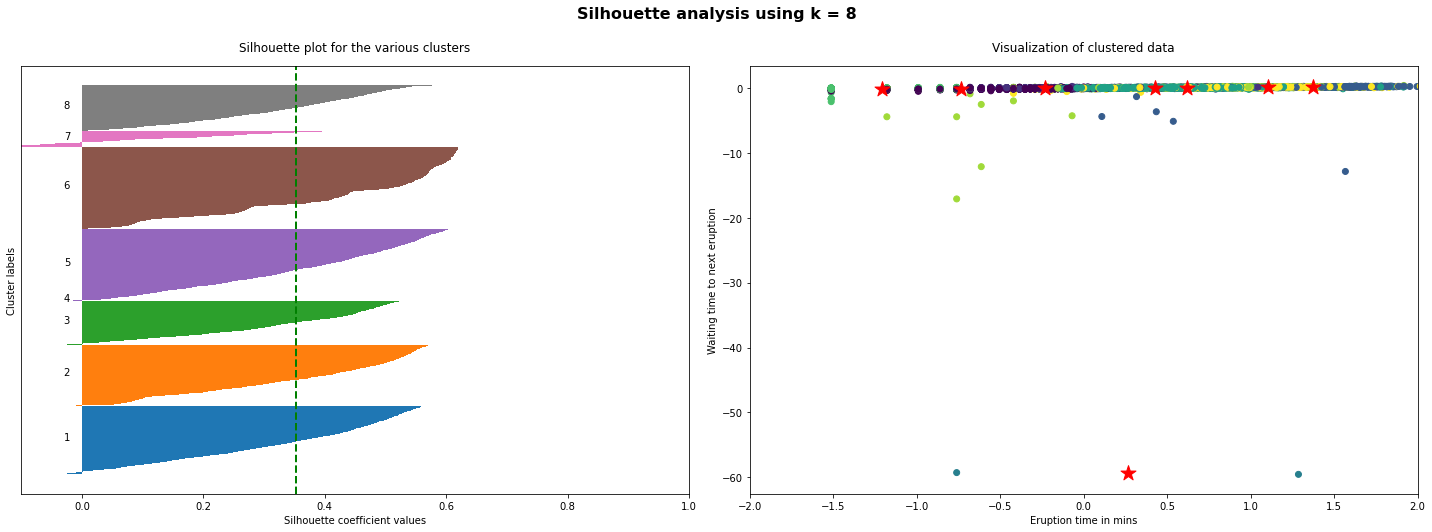

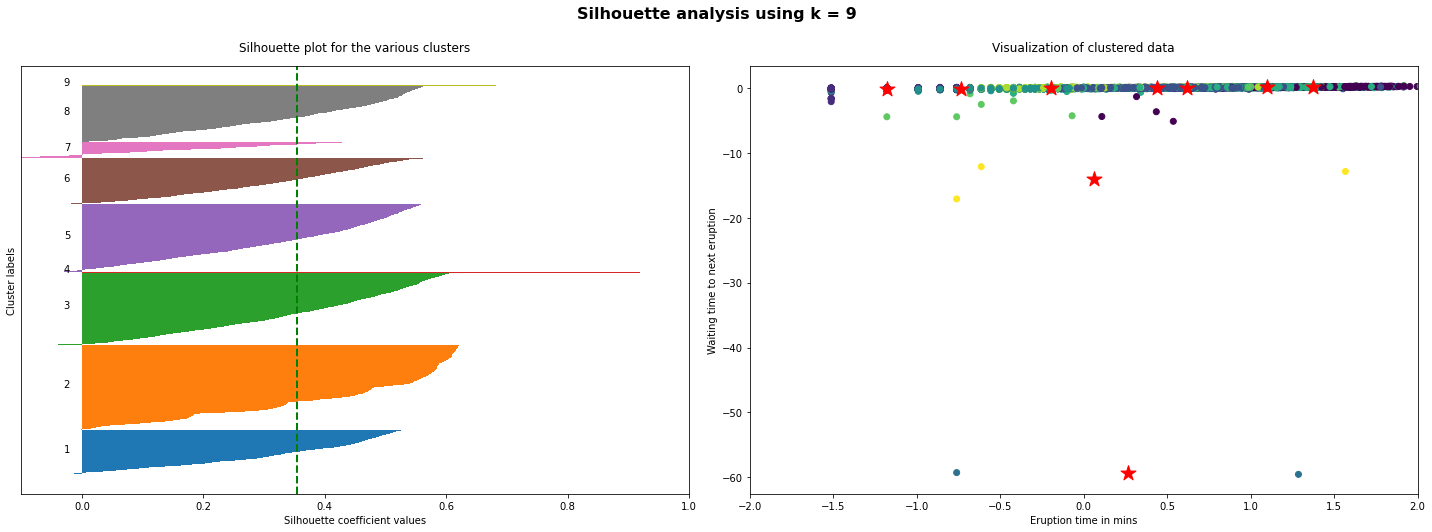

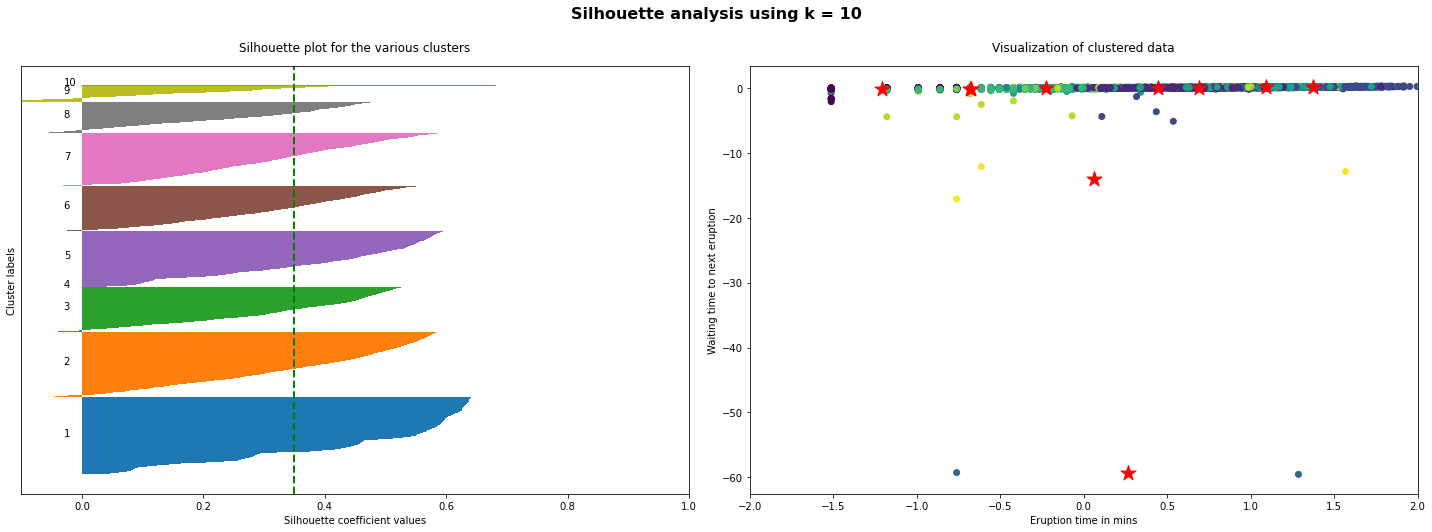

In [86]:
plot_silhouette(selected_data)

Using **3 and 4 clusters** appear to be the two optimal choices:
- 3 maximizes the average silhouette coefficient
- 4 represents a potential refunds group

In both cases, all clusters are above the average silhouette coefficient. There is however a certain degree of spill in cluster count 4, and in both cases there is a very significant size difference between clusters - noted by the width of the silhouette. This unbalance seems to be significantly smaller using 4 clusters.

As the number of cluster increases from 4 so does the cluster size imbalance and spillover effect.

### Silhouette Plot - Purchases Value vs Refunds Value

The silhouette plot although very significant, failed to properly visualize the cluster given a scatter plot is a 2D representation, and 5 feature vectors were passed. The following depicts the same silhouette analysis, considering purchases_value and refunds_value.

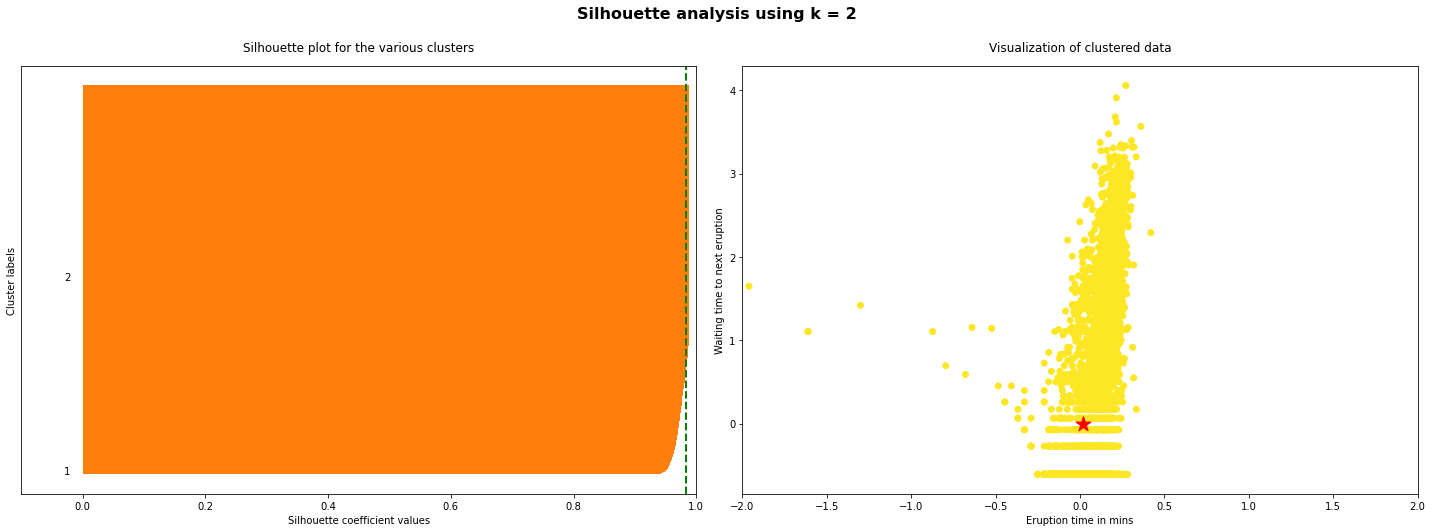

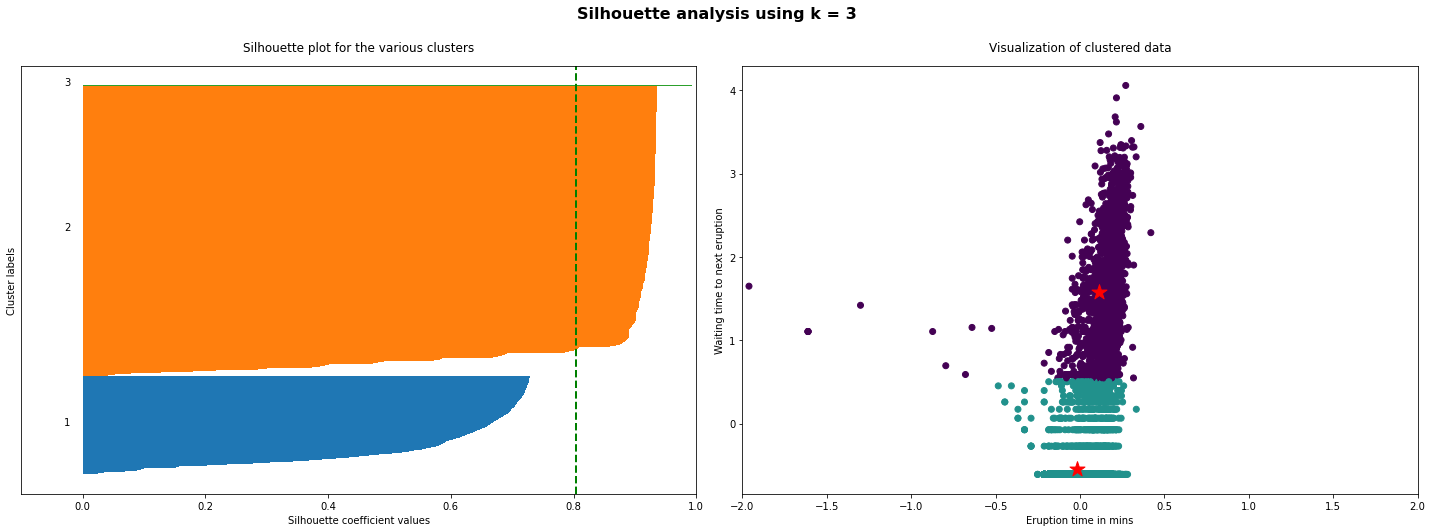

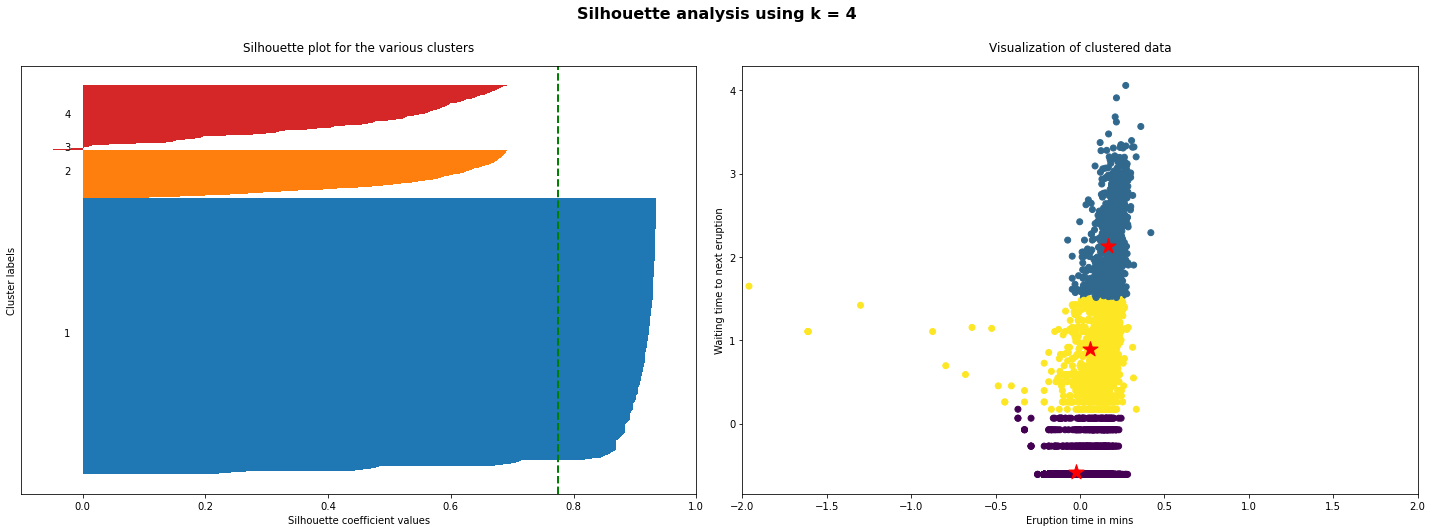

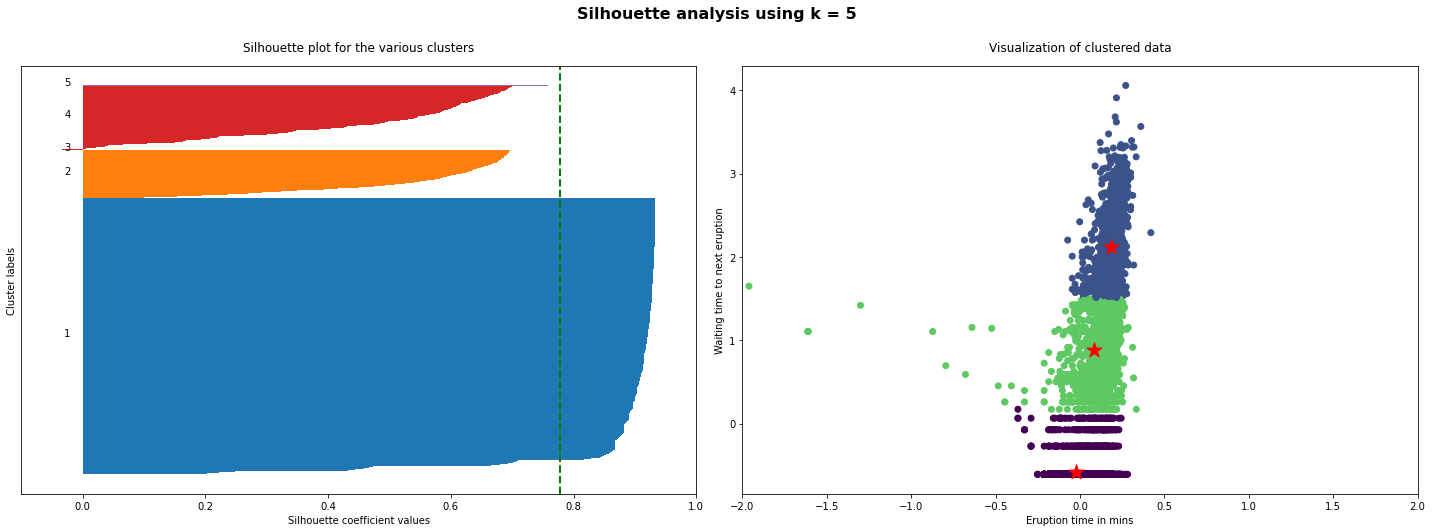

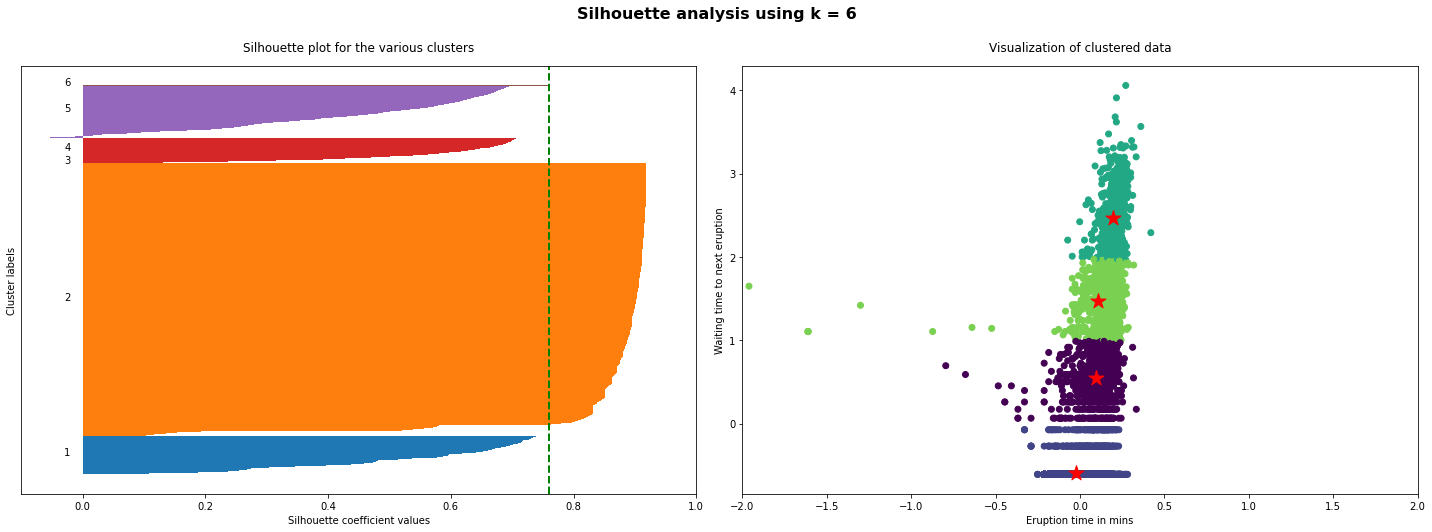

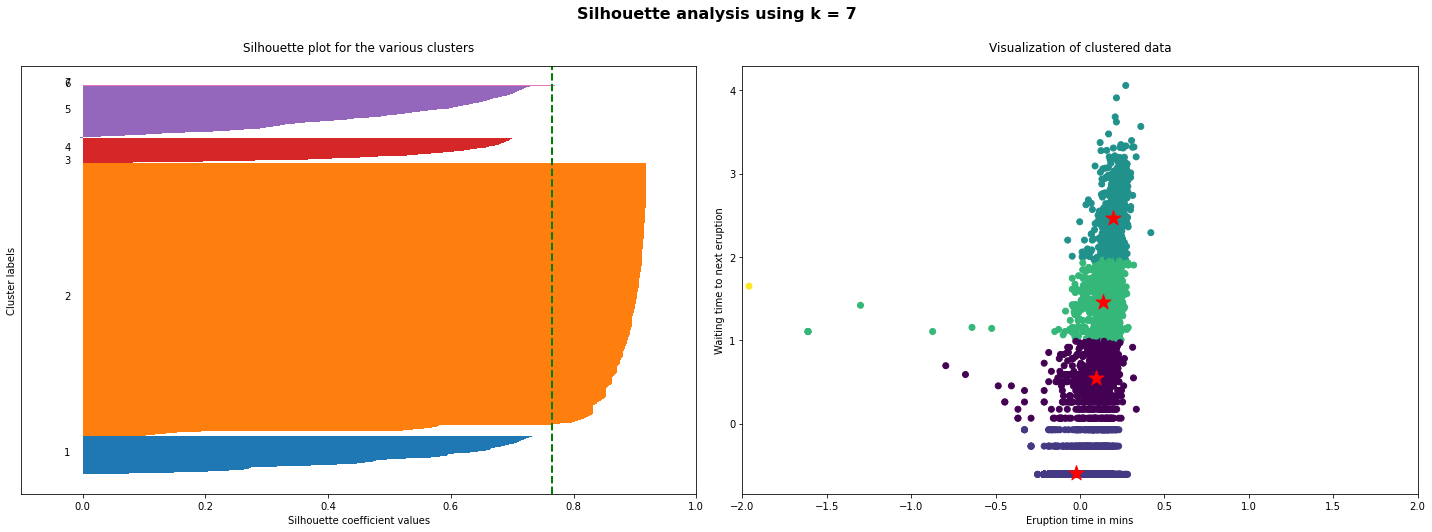

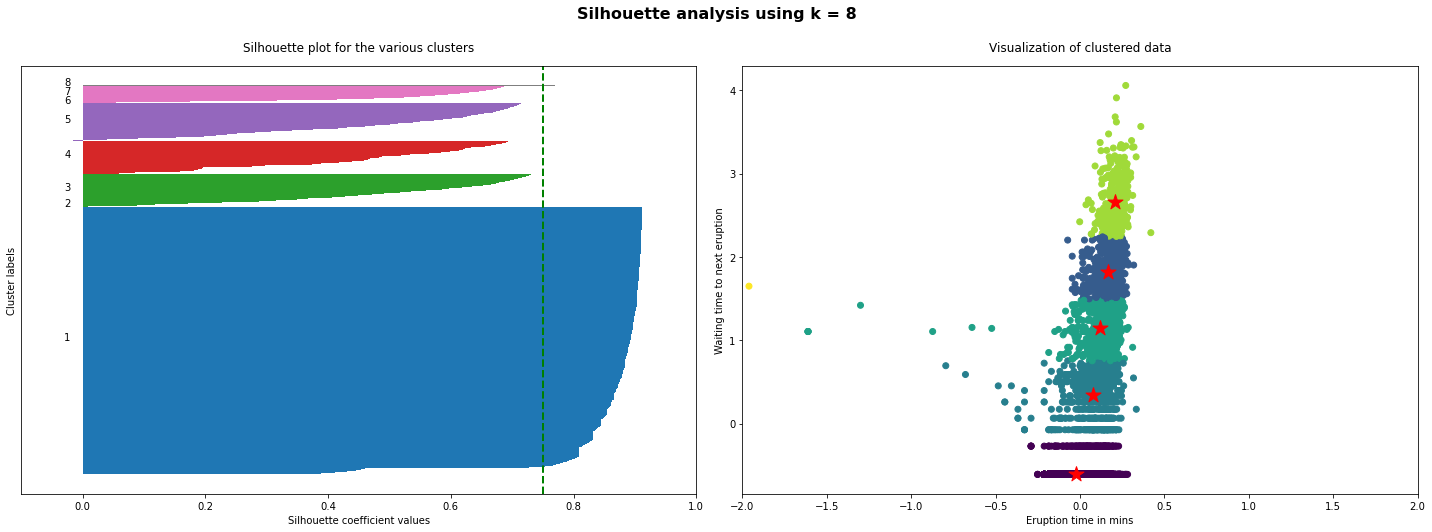

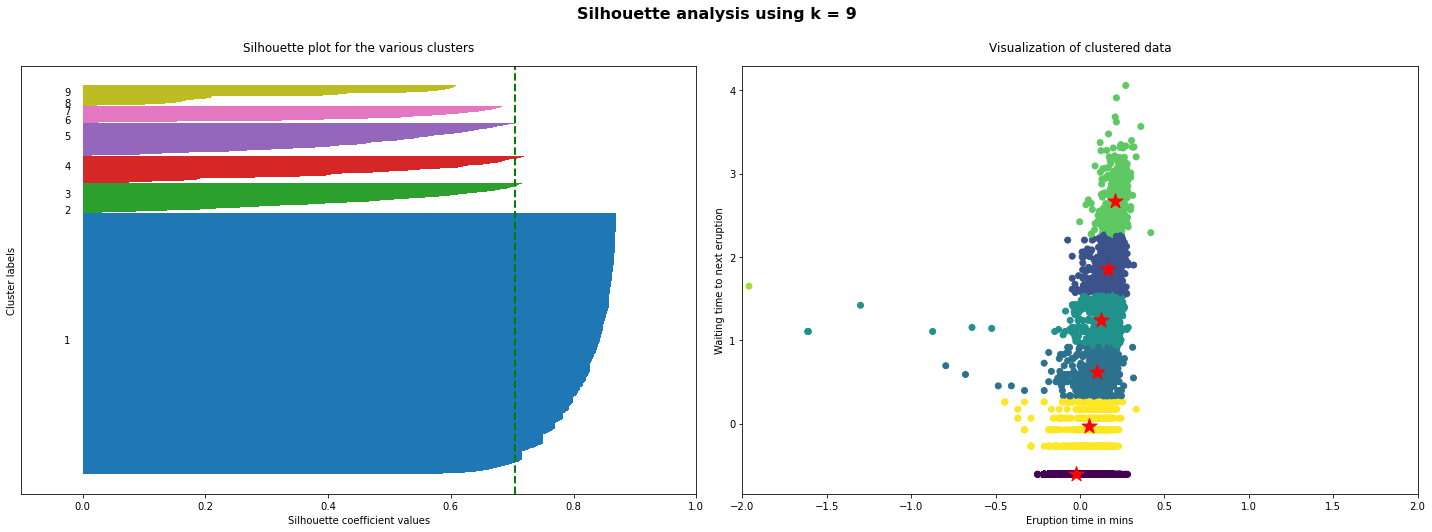

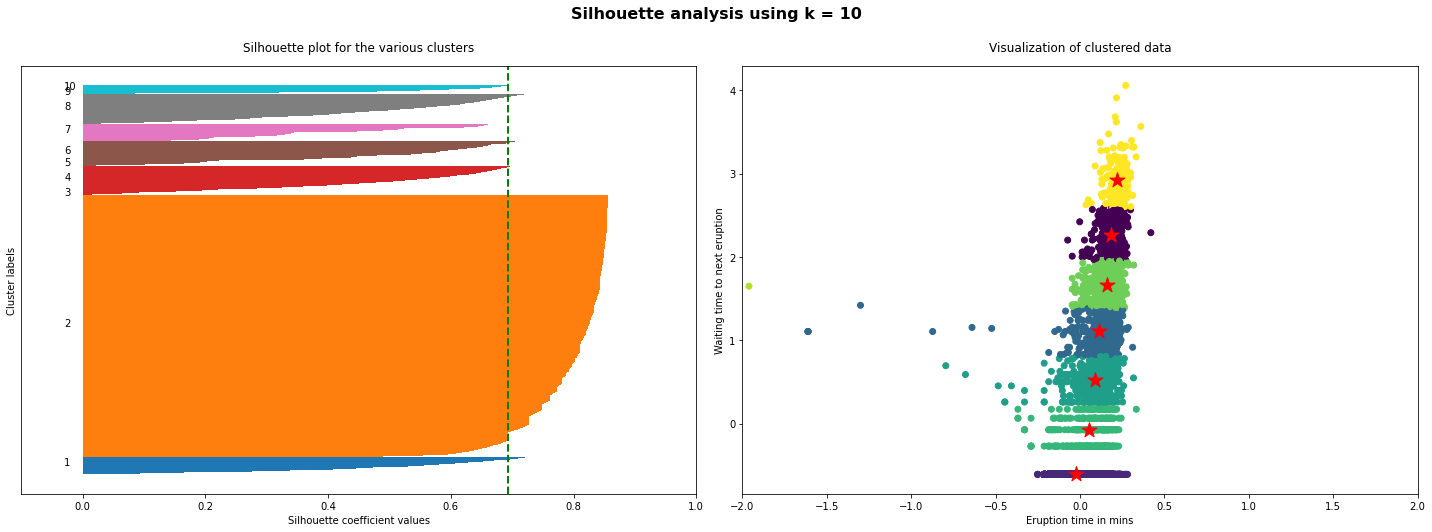

In [92]:
selected_features_reduced: List[str] = ['purchases_value', 'refunds_value']
variable_columns_reduced: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features_reduced))[0]
selected_data_reduced = cluster_data[:, variable_columns_reduced]

plot_silhouette(selected_data_reduced)

The previous cluster visualization shows well-defined cluster data segmentation on the right-hand plots, especially considering 3 and 4 clusters.

### Silhouette Plot -  Average Product Cost vs Refunds Value

To ensure the segmentation's quality, we visualized a few other sets of data groups and the selected model's data separation capabilities.

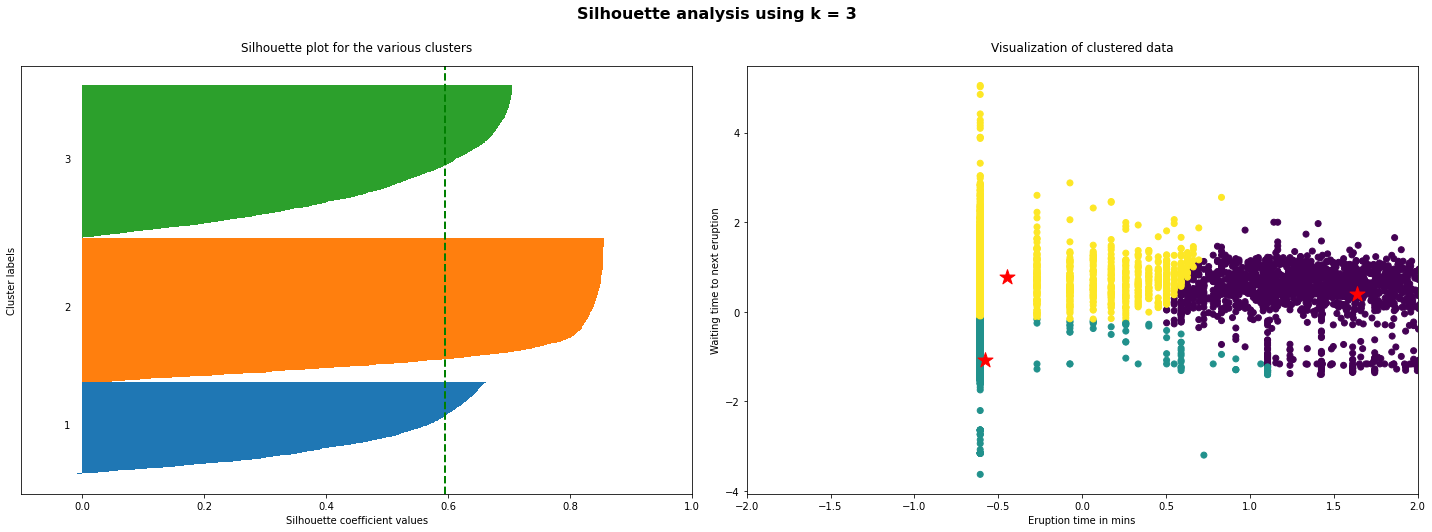

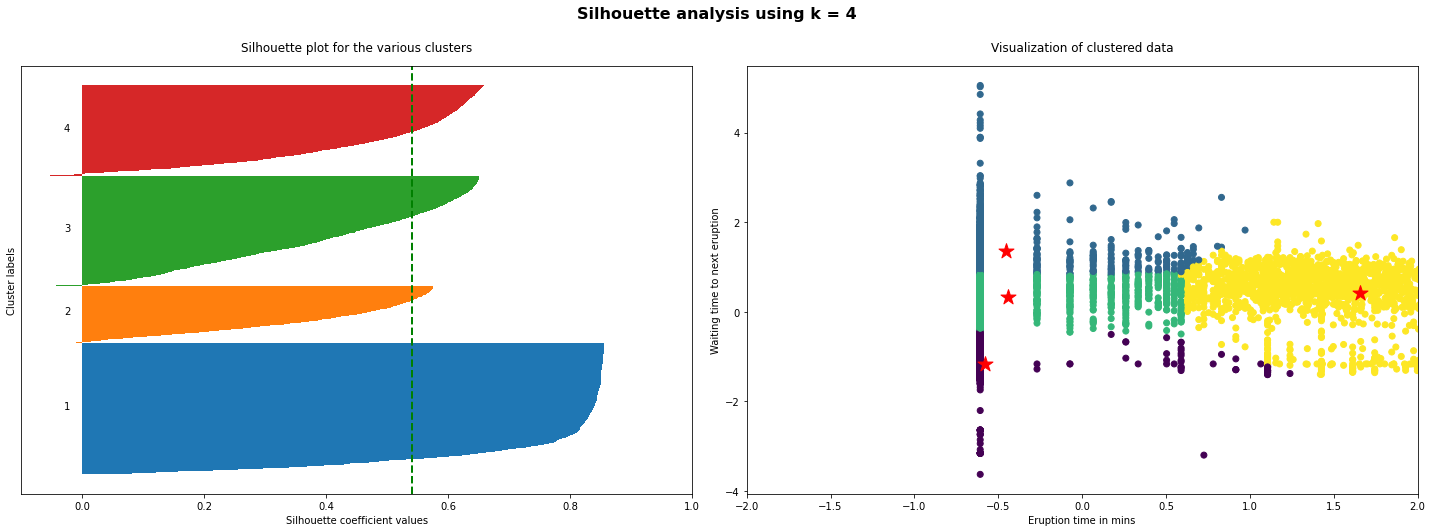

In [97]:
selected_features_reduced: List[str] = ['avg_product_cost', 'refunds_value']
variable_columns_reduced: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features_reduced))[0]
selected_data_reduced = cluster_data[:, variable_columns_reduced]

plot_silhouette(selected_data_reduced, min_clusters= 3, max_clusters= 4)

### Silhouette Plot -  Average Product Cost vs Purchases Value

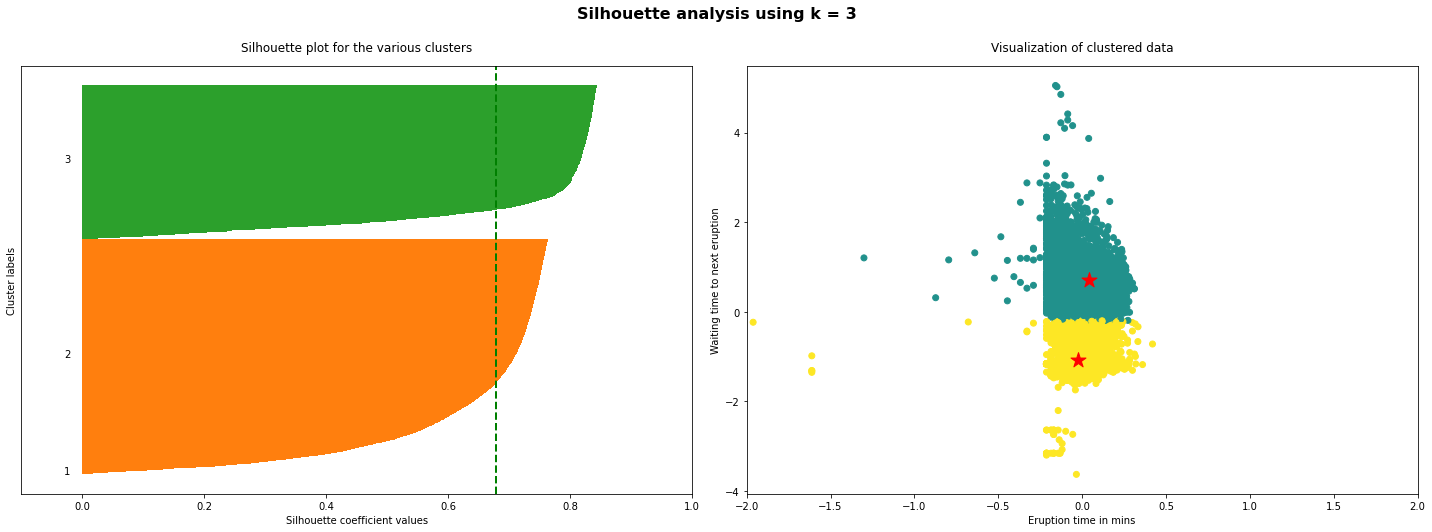

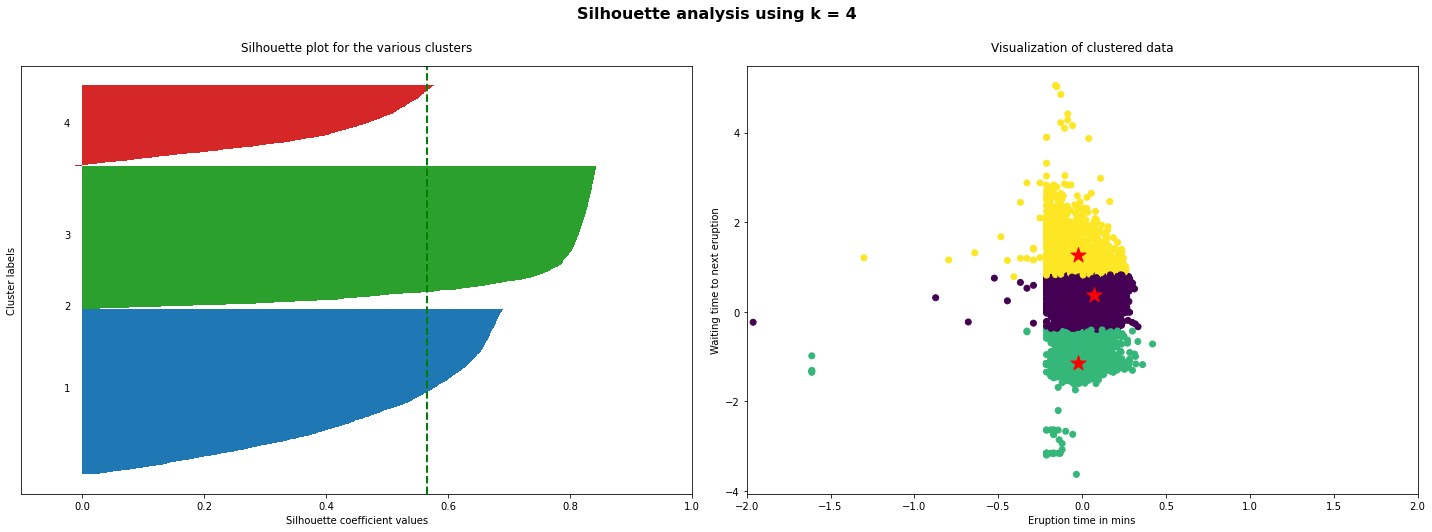

In [98]:
selected_features_reduced: List[str] = ['avg_product_cost', 'purchases_value']
variable_columns_reduced: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features_reduced))[0]
selected_data_reduced = cluster_data[:, variable_columns_reduced]

plot_silhouette(selected_data_reduced, min_clusters= 3, max_clusters= 4)

## K-Means

### Using 4 clusters

In [40]:
cluster_number: int = 4
model = KMeans(n_clusters= cluster_number, random_state= 30)
model.fit(selected_data)

# Attribute each user its cluster
rfm_table['cluster'] = model.labels_

rfm_table.groupby('cluster').agg({
    'purchases_count':'mean',
    'purchases_value':['mean', 'count'],
    'refunds_count': 'mean',
    'refunds_value': 'mean',
    'avg_product_cost': 'mean',
    'recency': 'mean',
    'time_between_purchases': 'mean'
}).round(1)

purchases_count purchases_value       refunds_count refunds_value  \
                   mean            mean count          mean          mean   
cluster                                                                     
0                 215.3          4996.1  3035           0.4           2.0   
1                  18.1          1392.1  2979           0.1           2.8   
2                 625.5         -1523.5     2         309.5        2186.5   
3                1747.7         48743.9  1919          31.7         371.7   

        avg_product_cost recency time_between_purchases  
                    mean    mean                   mean  
cluster                                                  
0                   87.6    89.0                   14.8  
1                    1.9   153.1                   29.6  
2                   56.1   257.5                    0.0  
3                   40.1     5.7                    0.7

In [33]:
clustered_data: pd.DataFrame = clean_data.merge(rfm_table[['cac', 'cluster']])

In [34]:
# Analyse if clusters belong to a specific country
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('country_code')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
country_code
country_code_3    1013
country_code_2     969
country_code_0     697
country_code_1     356
Name: cac, dtype: int64
Cluster:  1
country_code
country_code_2    1411
country_code_0     627
country_code_3     617
country_code_1     325
Name: cac, dtype: int64
Cluster:  2
country_code
country_code_2    2
Name: cac, dtype: int64
Cluster:  3
country_code
country_code_2    766
country_code_0    486
country_code_1    437
country_code_3    230
Name: cac, dtype: int64


In [35]:
# Analyse if clusters belong to a specific group
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('group')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
group
group_3        2912
group_5        2239
group_6        1807
group_0        1664
group_7         992
group_other     381
Name: cac, dtype: int64
Cluster:  1
group
group_3        2488
group_5        1079
group_6         819
group_0         528
group_7         208
group_other      12
Name: cac, dtype: int64
Cluster:  2
group
group_6        2
group_5        2
group_3        2
group_other    1
group_7        1
group_0        1
Name: cac, dtype: int64
Cluster:  3
group
group_3        1917
group_5        1904
group_6        1883
group_0        1873
group_7        1683
group_other    1126
Name: cac, dtype: int64


In [38]:
# Analyse if clusters belong to a specific region
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('region_group')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
region_group
region_13       2450
region_5        2402
region_16       2193
region_7        1974
region_3        1819
region_0        1664
region_9        1627
region_8        1614
region_12       1558
region_6        1541
region_11       1394
region_19       1393
region_15       1366
region_18       1213
region_17       1013
region_14        949
region_other     810
region_10        551
Name: cac, dtype: int64
Cluster:  1
region_group
region_13       1594
region_5        1220
region_16        860
region_8         657
region_7         647
region_3         591
region_12        580
region_0         528
region_9         358
region_11        322
region_6         310
region_18        293
region_19        242
region_15        218
region_14        206
region_17        161
region_10        135
region_other     123
Name: cac, dtype: int64
Cluster:  2
region_group
region_16       2
region_8        2
region_6        2
region_12       2
region_13       2
region_other    1
region_10    

In [37]:
# Analyse if clusters belong to a specific group
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('product_family')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
product_family
product_family_5        2402
product_family_22       2193
product_family_17       1978
product_family_7        1974
product_family_16       1951
product_family_3        1819
product_family_other    1794
product_family_0        1664
product_family_18       1558
product_family_6        1541
product_family_14       1539
product_family_9        1503
product_family_8        1361
product_family_15       1217
product_family_25       1143
product_family_33       1033
product_family_32       1020
product_family_31        887
product_family_27        806
product_family_30        797
product_family_40        785
product_family_23        769
product_family_36        708
product_family_37        685
product_family_24        558
product_family_44        543
product_family_69        511
product_family_12        459
product_family_13        413
product_family_83        321
Name: cac, dtype: int64
Cluster:  1
product_family
product_family_5        1220
product_family_17      

In [36]:
# Analyse if clusters belong to a specific company_area
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('company_area')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
company_area
company_area_5        2402
company_area_19       2193
company_area_15       1978
company_area_7        1974
company_area_14       1951
company_area_3        1819
company_area_16       1700
company_area_0        1664
company_area_8        1614
company_area_12       1558
company_area_9        1547
company_area_6        1541
company_area_11       1394
company_area_18       1366
company_area_13       1217
company_area_21       1213
company_area_24       1085
company_area_22       1052
company_area_20       1013
company_area_other     882
company_area_29        739
company_area_26        713
company_area_10        551
company_area_17        426
Name: cac, dtype: int64
Cluster:  1
company_area
company_area_5        1220
company_area_15        905
company_area_19        860
company_area_14        846
company_area_8         657
company_area_7         647
company_area_16        645
company_area_3         591
company_area_12        580
company_area_0         528
company_

### Using 3 clusters

In [39]:
cluster_number: int = 3
model = KMeans(n_clusters= cluster_number, random_state= 30)
model.fit(selected_data)

# Attribute each user its cluster
rfm_table['cluster'] = model.labels_

rfm_table.groupby('cluster').agg({
    'purchases_count':'mean',
    'purchases_value':['mean', 'count'],
    'refunds_count': 'mean',
    'refunds_value': 'mean',
    'avg_product_cost': 'mean',
    'recency': 'mean',
    'time_between_purchases': 'mean'
}).round(1)

purchases_count purchases_value       refunds_count refunds_value  \
                   mean            mean count          mean          mean   
cluster                                                                     
0                 101.5          2787.2  5849           0.2           1.8   
1                1663.8         46327.9  2084          29.4         344.2   
2                 625.5         -1523.5     2         309.5        2186.5   

        avg_product_cost recency time_between_purchases  
                    mean    mean                   mean  
cluster                                                  
0                   44.9   123.6                   22.7  
1                   41.2     6.9                    0.9  
2                   56.1   257.5                    0.0

In [40]:
clustered_data: pd.DataFrame = clean_data.merge(rfm_table[['cac', 'cluster']])

In [45]:
# Analyse if clusters belong to a specific country
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('country_code')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
country_code
country_code_2    2325
country_code_3    1586
country_code_0    1288
country_code_1     651
Name: cac, dtype: int64
Cluster:  1
country_code
country_code_2    821
country_code_0    522
country_code_1    467
country_code_3    274
Name: cac, dtype: int64
Cluster:  2
country_code
country_code_2    2
Name: cac, dtype: int64


In [44]:
# Analyse if clusters belong to a specific group
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('group')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
group
group_3        5236
group_5        3160
group_6        2477
group_0        2044
group_7        1085
group_other     332
Name: cac, dtype: int64
Cluster:  1
group
group_3        2081
group_5        2062
group_6        2032
group_0        2021
group_7        1798
group_other    1187
Name: cac, dtype: int64
Cluster:  2
group
group_6        2
group_5        2
group_3        2
group_other    1
group_7        1
group_0        1
Name: cac, dtype: int64


In [43]:
# Analyse if clusters belong to a specific region
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('region_group')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
region_group
region_13       3886
region_5        3462
region_16       2890
region_7        2467
region_3        2262
region_8        2124
region_0        2044
region_12       1999
region_9        1837
region_6        1706
region_11       1583
region_19       1492
region_15       1448
region_18       1375
region_17       1061
region_14       1041
region_other     827
region_10        619
Name: cac, dtype: int64
Cluster:  1
region_group
region_13       2074
region_5        2070
region_16       2064
region_7        2050
region_3        2023
region_0        2021
region_9        2012
region_8        2000
region_6        1997
region_12       1996
region_19       1981
region_11       1954
region_15       1939
region_18       1903
region_14       1783
region_17       1778
region_other    1736
region_10       1452
Name: cac, dtype: int64
Cluster:  2
region_group
region_16       2
region_8        2
region_6        2
region_12       2
region_13       2
region_other    1
region_10    

In [42]:
# Analyse if clusters belong to a specific group
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('product_family')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
product_family
product_family_5        3462
product_family_22       2890
product_family_17       2729
product_family_16       2641
product_family_7        2467
product_family_other    2302
product_family_3        2262
product_family_0        2044
product_family_18       1967
product_family_14       1923
product_family_6        1706
product_family_8        1648
product_family_9        1610
product_family_15       1350
product_family_25       1252
product_family_33       1054
product_family_32       1000
product_family_31        881
product_family_40        854
product_family_27        847
product_family_23        826
product_family_30        789
product_family_36        660
product_family_37        654
product_family_24        596
product_family_44        577
product_family_69        514
product_family_12        478
product_family_13        376
product_family_83        320
Name: cac, dtype: int64
Cluster:  1
product_family
product_family_5        2070
product_family_22      

In [41]:
# Analyse if clusters belong to a specific company_area
for cluster in range(0, cluster_number):
    print('Cluster: ', cluster)
    print(clustered_data[clustered_data.cluster == cluster].groupby('company_area')['cac']\
          .apply(lambda x: x.unique().shape[0]).sort_values(ascending= False))

Cluster:  0
company_area
company_area_5        3462
company_area_19       2890
company_area_15       2729
company_area_14       2641
company_area_7        2467
company_area_3        2262
company_area_16       2201
company_area_8        2124
company_area_0        2044
company_area_12       1999
company_area_6        1706
company_area_9        1668
company_area_11       1583
company_area_18       1448
company_area_21       1375
company_area_13       1350
company_area_24       1114
company_area_20       1061
company_area_22       1043
company_area_other     913
company_area_26        769
company_area_29        765
company_area_10        619
company_area_17        414
Name: cac, dtype: int64
Cluster:  1
company_area
company_area_5        2070
company_area_19       2064
company_area_14       2051
company_area_7        2050
company_area_15       2049
company_area_3        2023
company_area_0        2021
company_area_16       2017
company_area_8        2000
company_area_6        1997
company_

## k-Means - Conclusion

The k-Means algorithm performed quite well, achieving an average silhouette score of 0.67, with well-defined, balanced clusters, which carry business significance. Five features were used for clustering: *purchases_count*, *purchases_value*, *refunds_count*, *refunds_value*, *avg_product_cost*.

Two sets outputs were considered: using 3 and 4 clusters. The second option carries higher business significance and value-added, being able to determine a cluster composed of dissatisfied customers - using the refunds as a proxy for customer satisfaction.

# DBScan

The DBScan algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBScan can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBScan is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). 

DBScan, like OPTICS is particularly suitable for datasets with non-flat geometry and uneven cluster sizes.

The k-Means analysis showed the data appears to be linearly separable, so we expect DBScan to perform poorly. Nonetheless, for the sake of completeness, we opted for generating clusters assuming non-linear separability.

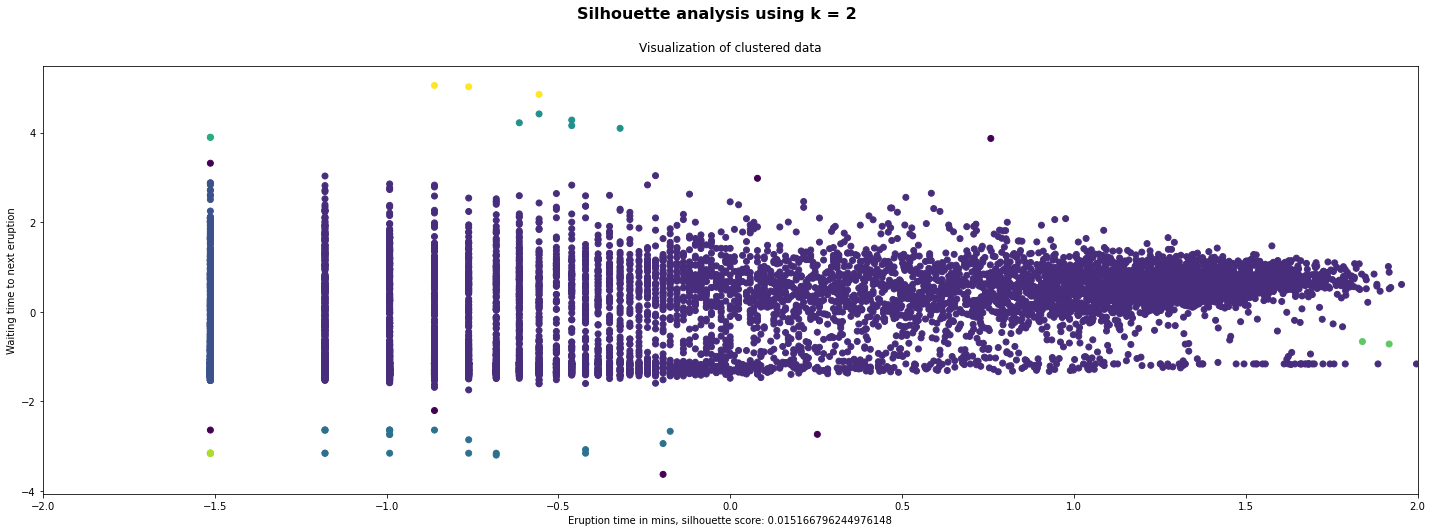

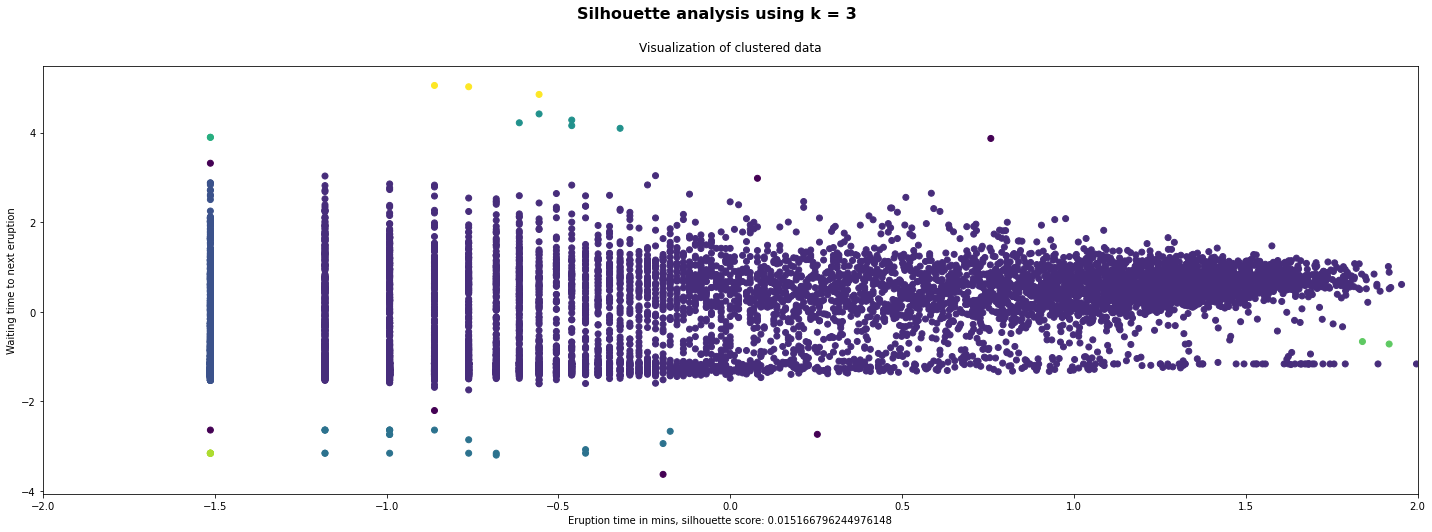

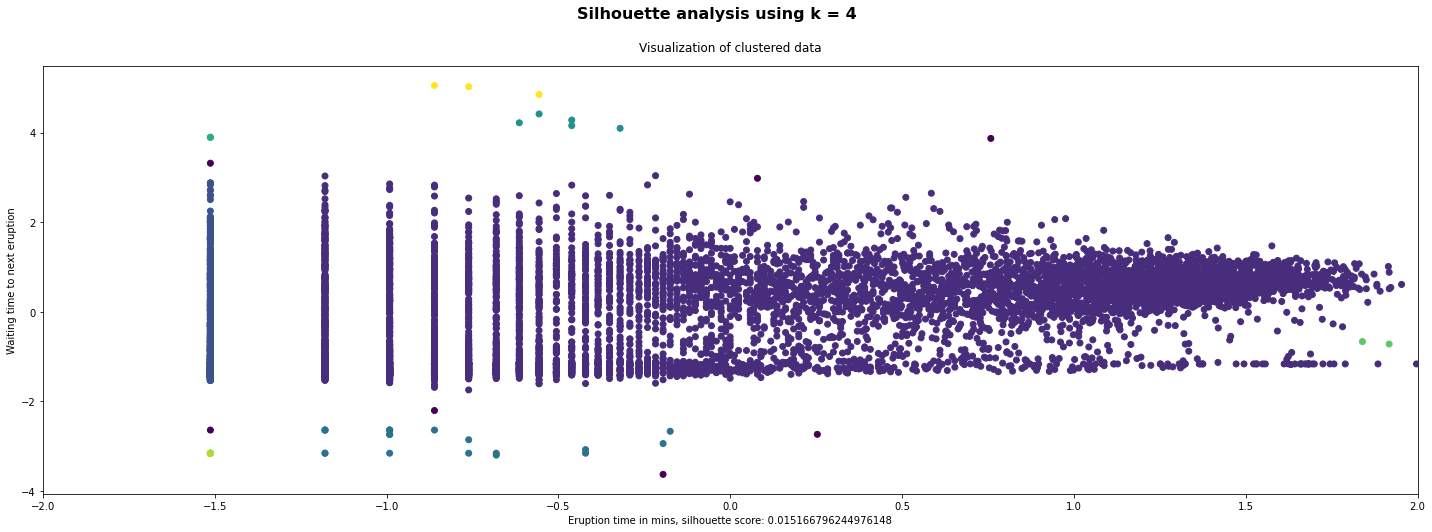

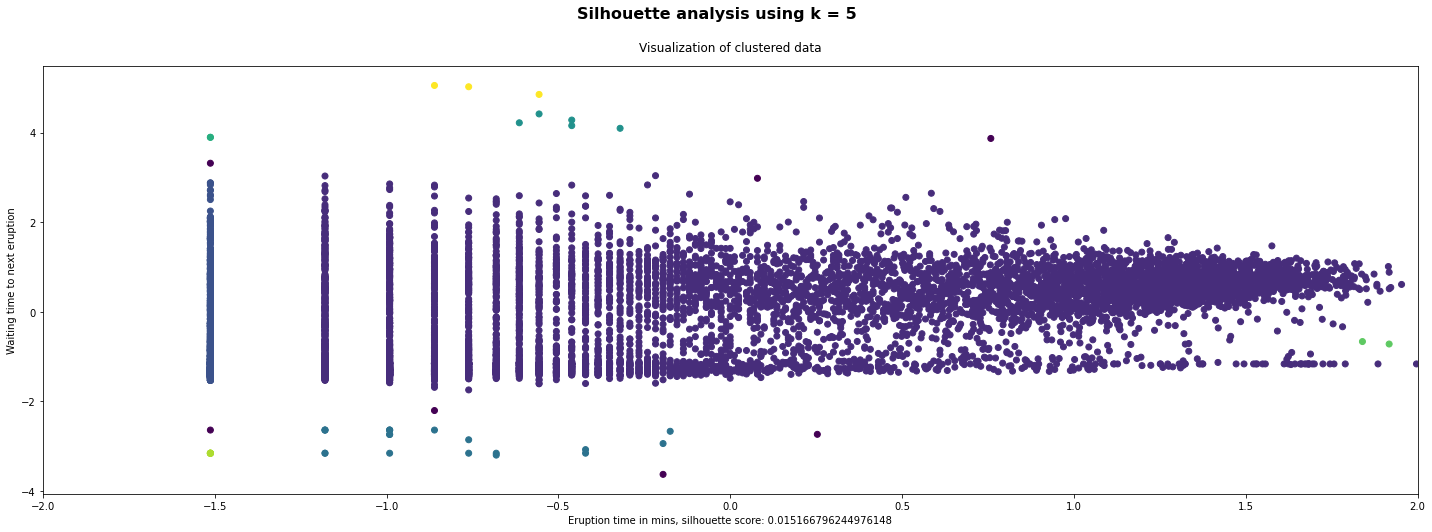

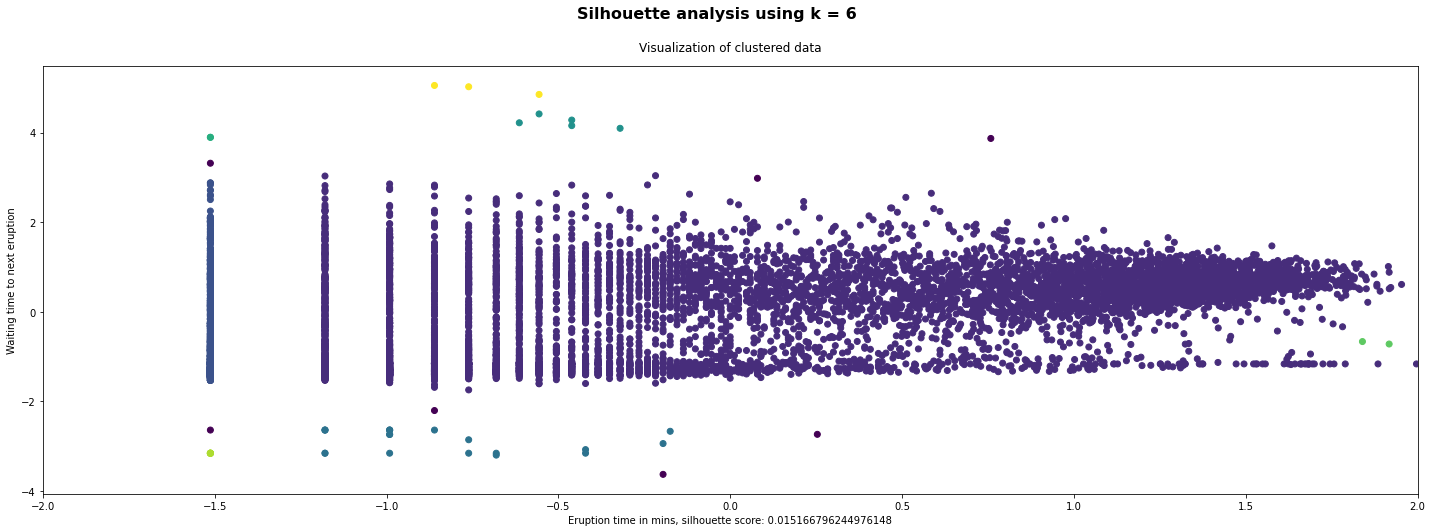

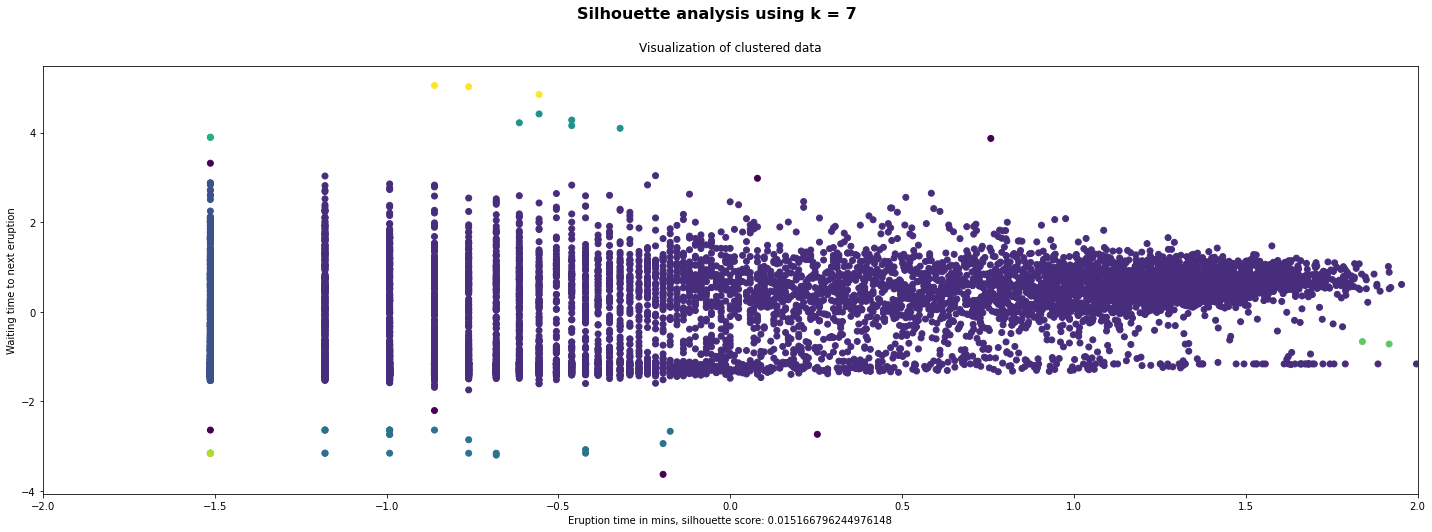

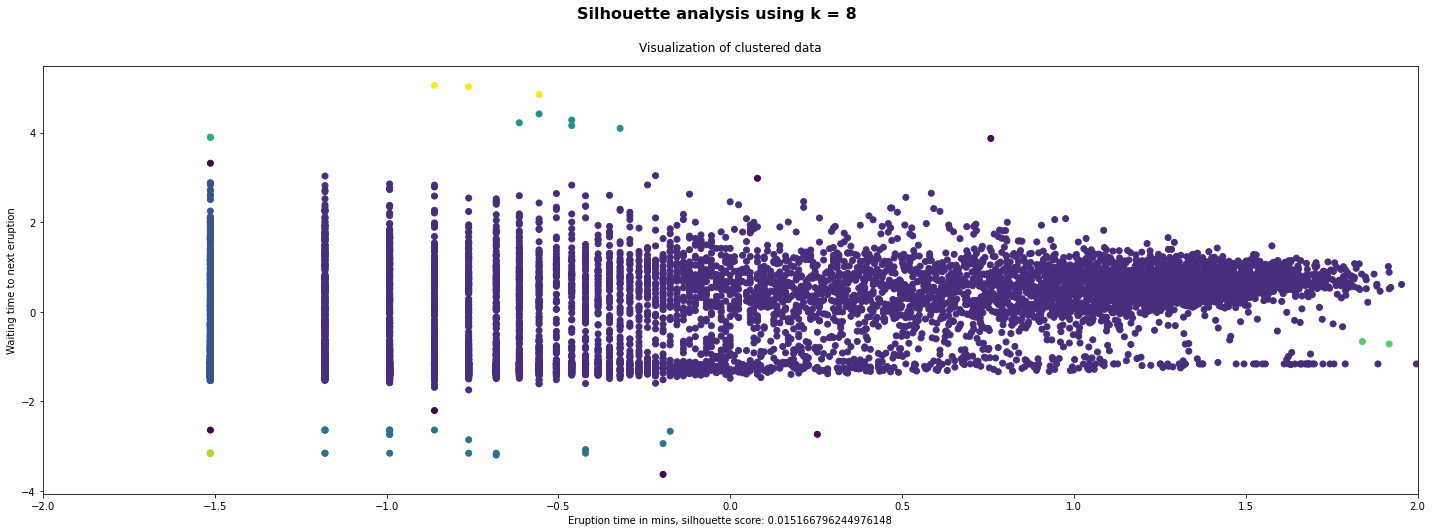

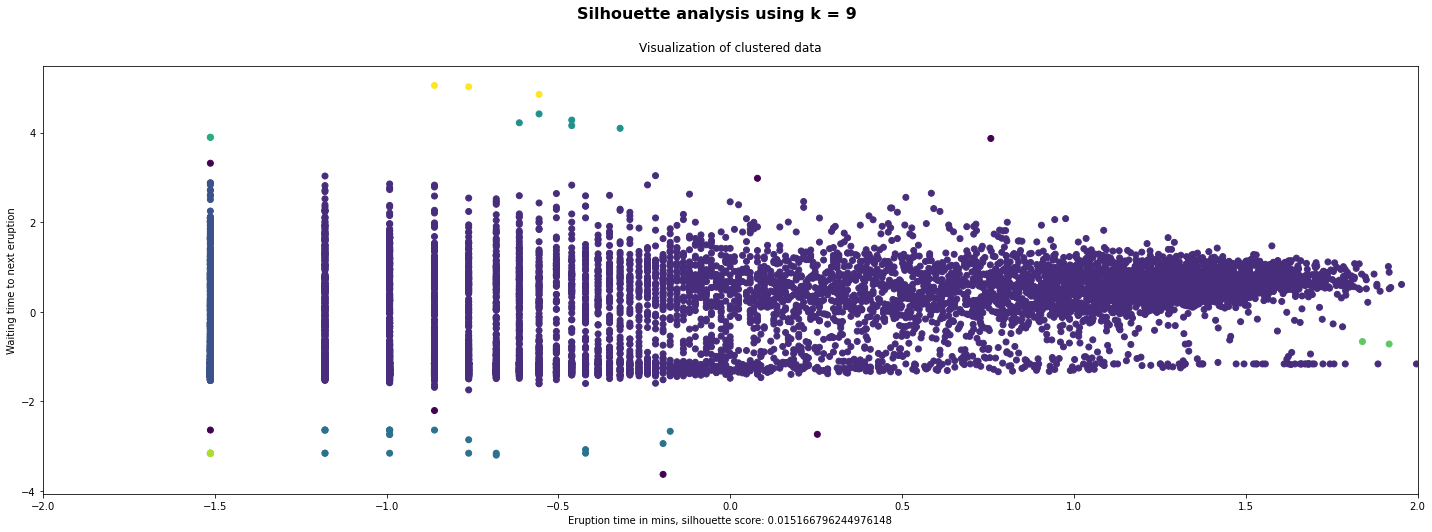

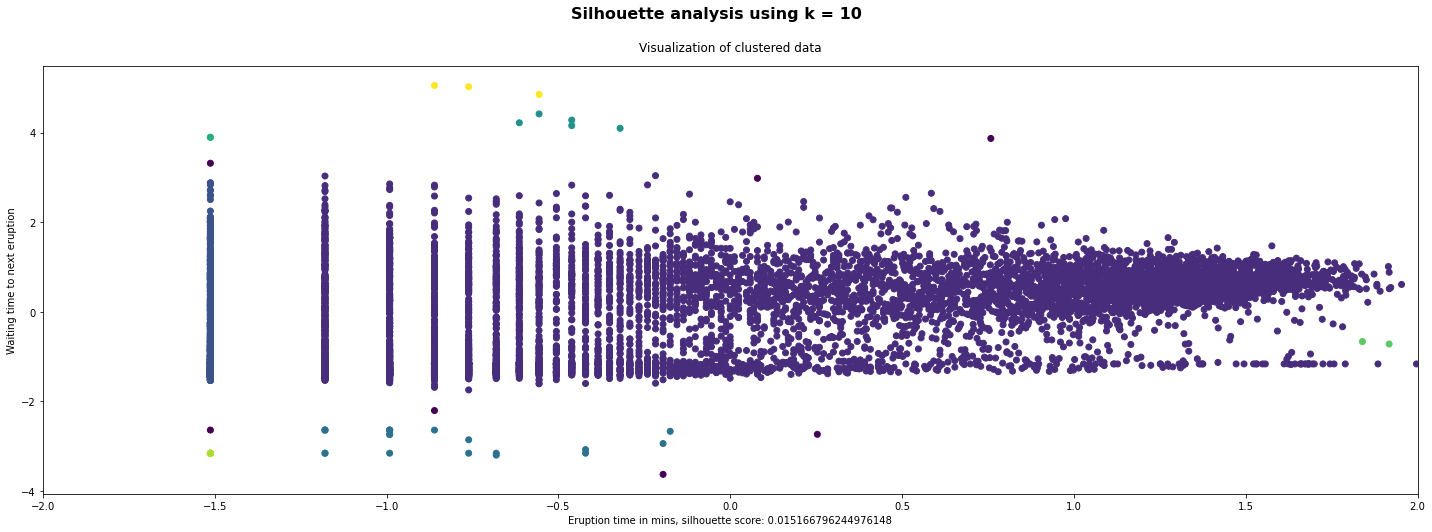

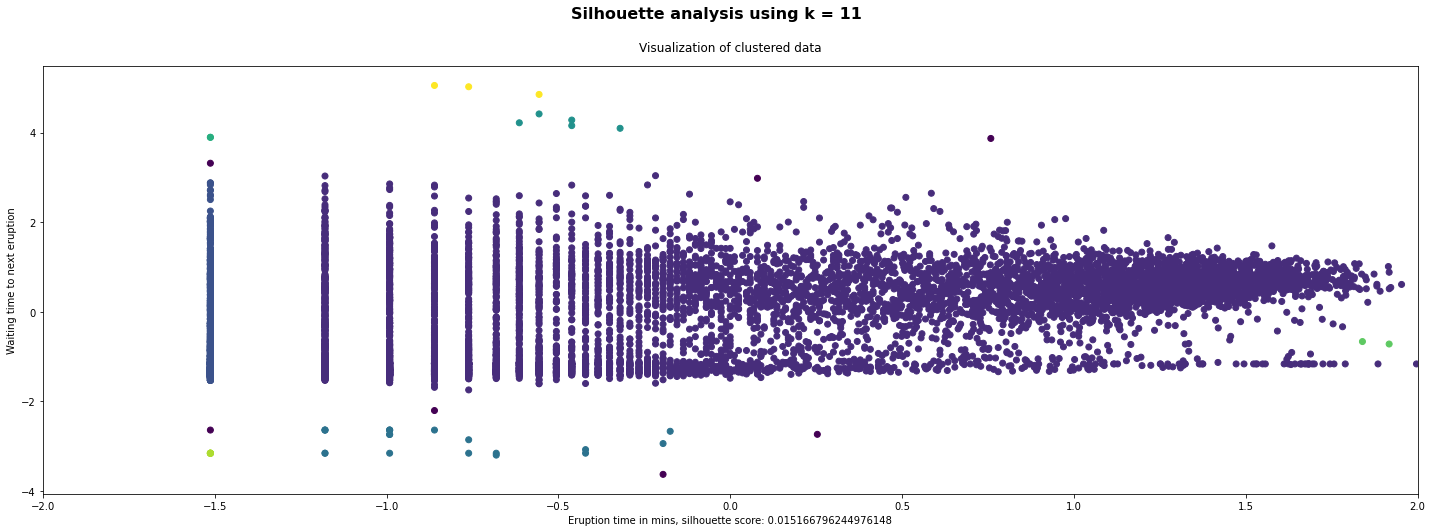

In [69]:
selected_features: List[str] = ['purchases_count', 'avg_product_cost']
variable_columns: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features))[0]
selected_data = cluster_data[:, variable_columns]

def plot_silhouette_dbscan(data, min_clusters= 2, max_clusters = 11):
    for i, k in enumerate(range(min_clusters, max_clusters +1)):
        fig, (ax2) = plt.subplots(1, 1)
        fig.set_size_inches(20, 7)

        # Run the DBScan algorithm
        dbscan = DBSCAN(eps = 0.3, min_samples = 2)
        labels = dbscan.fit_predict(data)
        
        silhouette_score = metrics.silhouette_score(data, labels)

        # Scatter plot of data colored with labels
        ax2.scatter(data[:, 0], data[:, 1], c=labels)
        ax2.set_xlim([-2, 2])
        ax2.set_xlim([-2, 2])
        ax2.set_xlabel(f'Eruption time in mins, silhouette score: {silhouette_score}')
        ax2.set_ylabel('Waiting time to next eruption')
        ax2.set_title('Visualization of clustered data', y=1.02)
        ax2.set_aspect('auto')
        plt.tight_layout()
        plt.suptitle(f'Silhouette analysis using k = {k}',
                     fontsize=16, fontweight='semibold', y=1.05);

plot_silhouette_dbscan(selected_data)

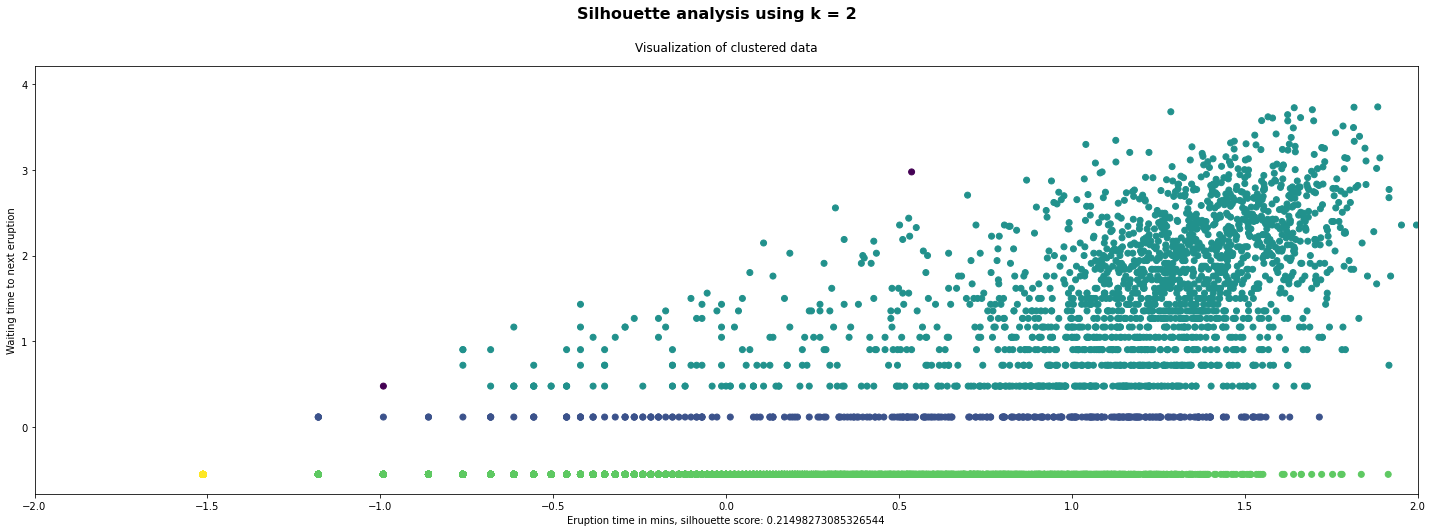

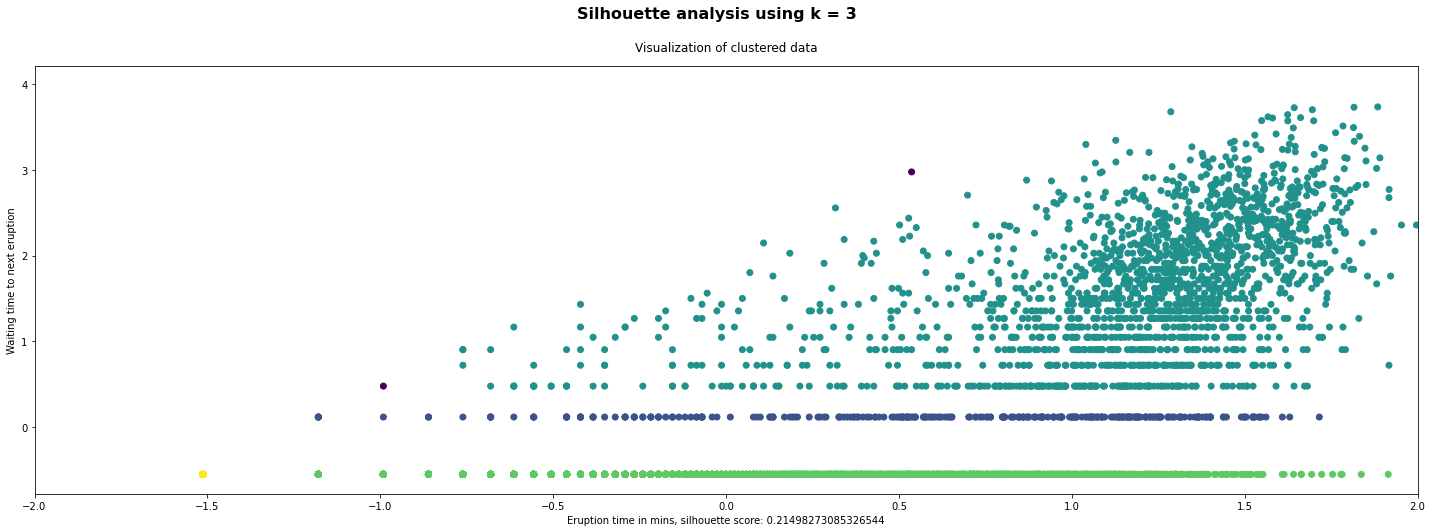

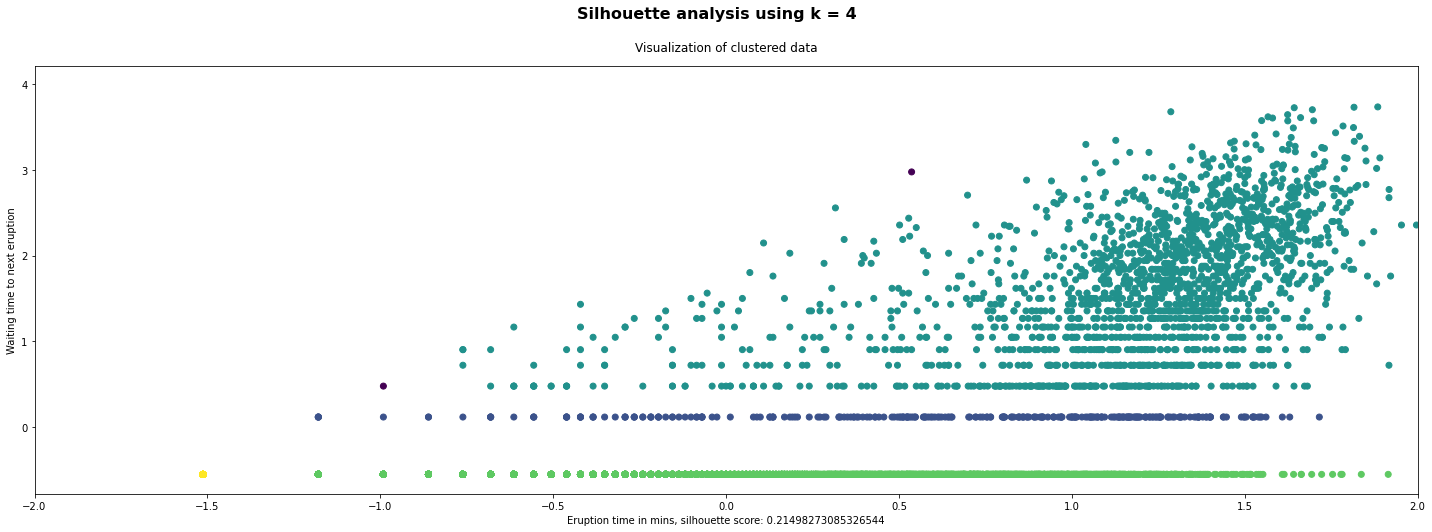

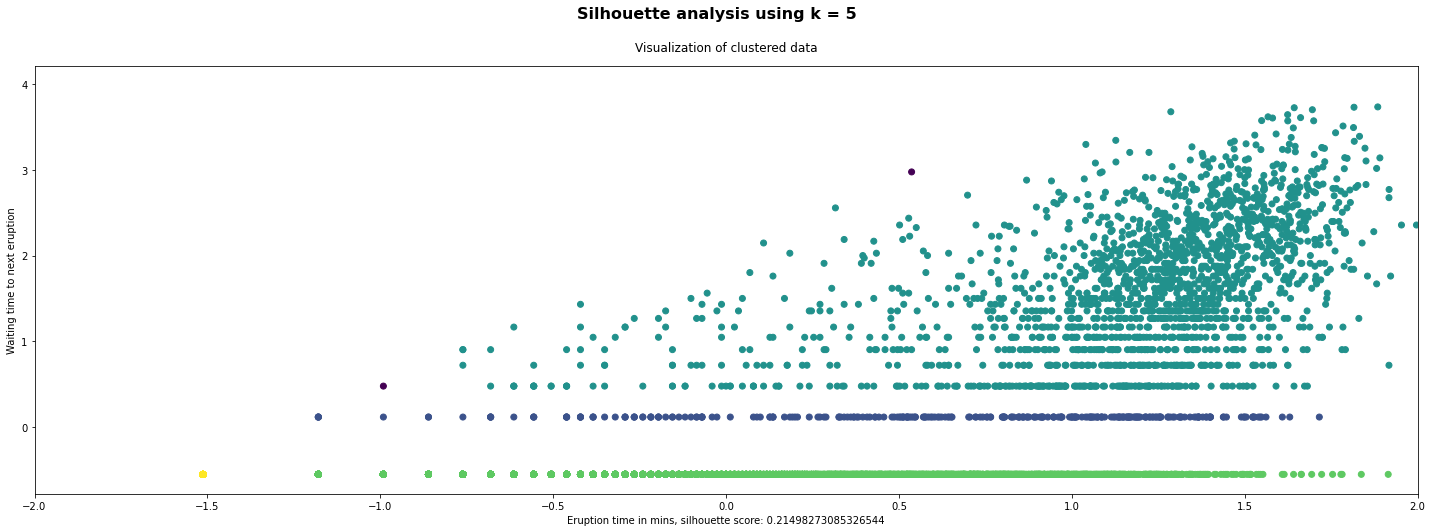

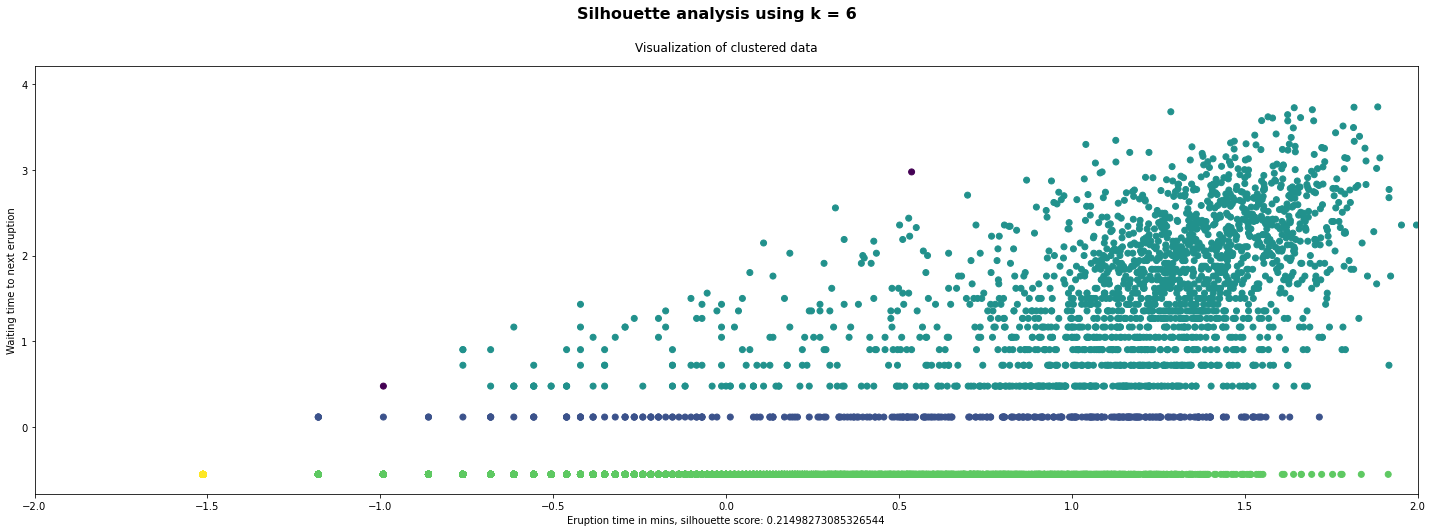

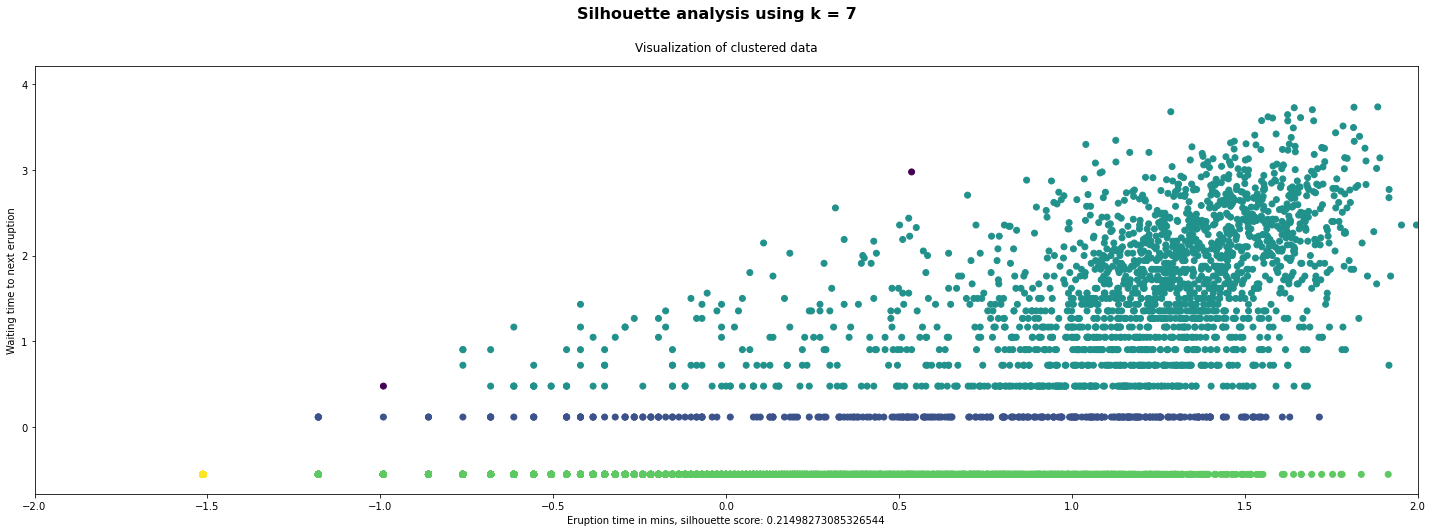

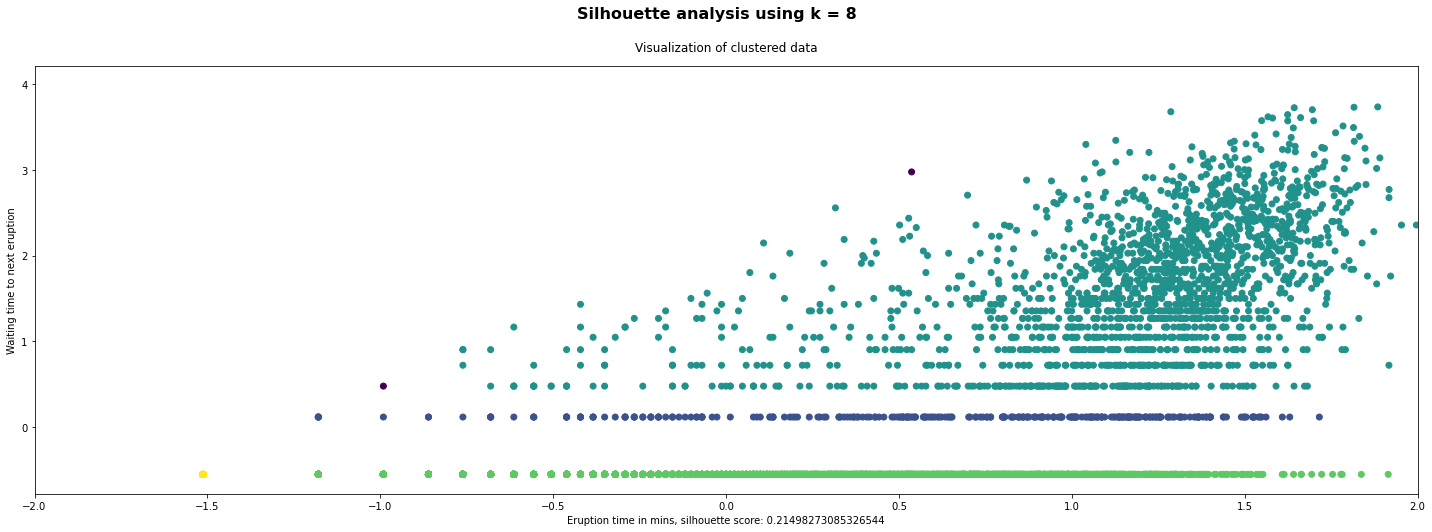

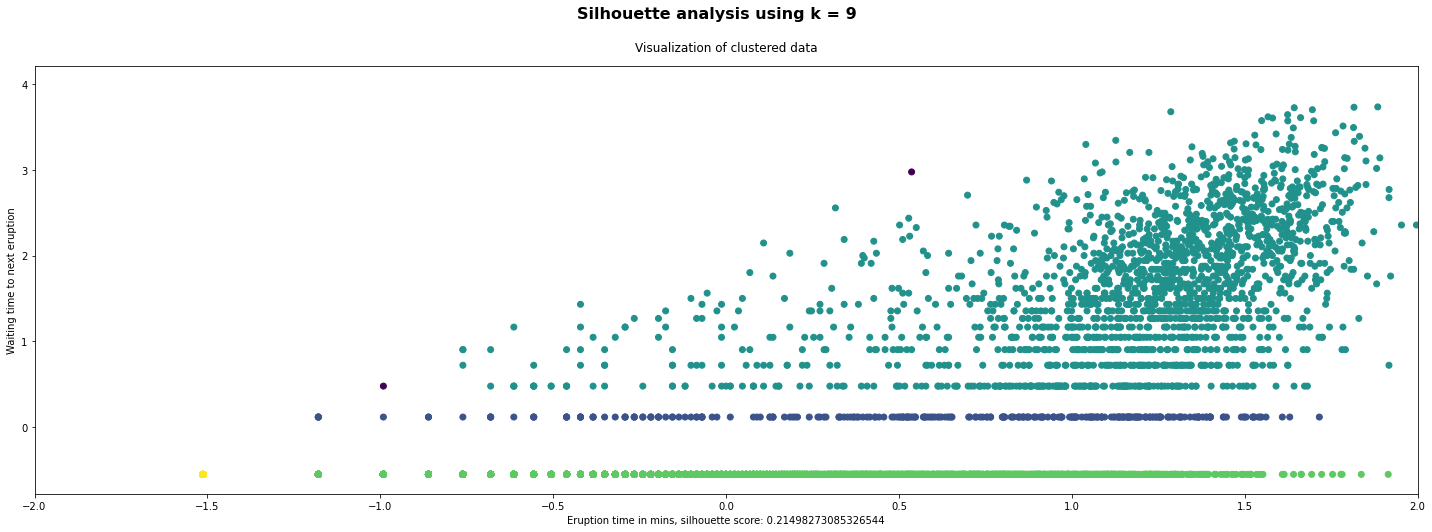

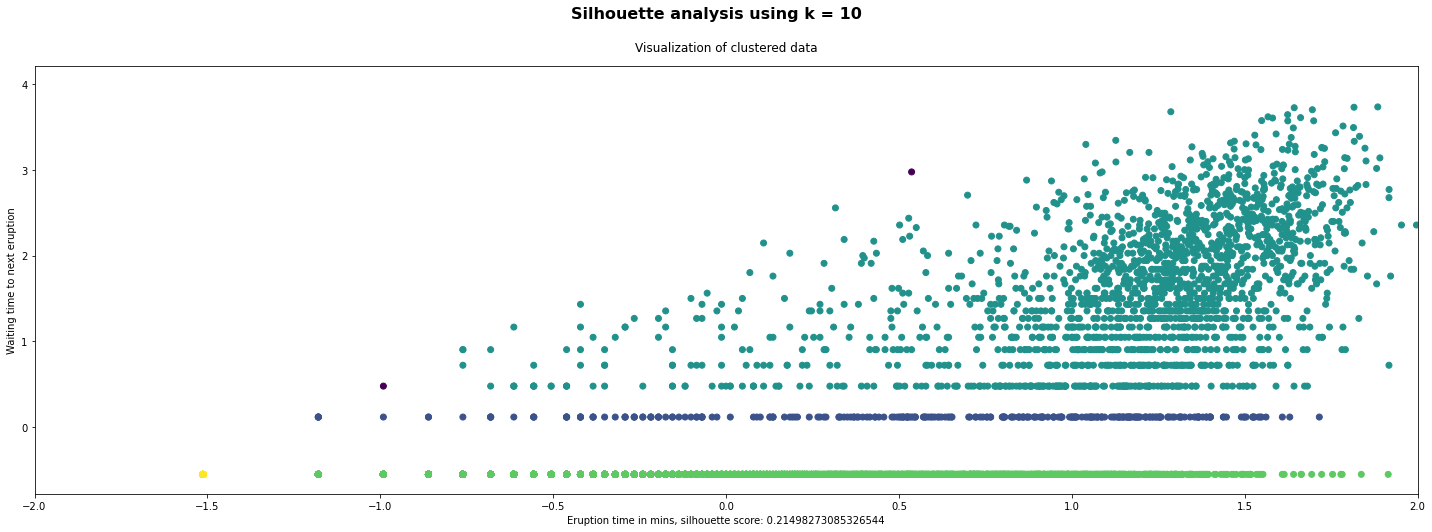

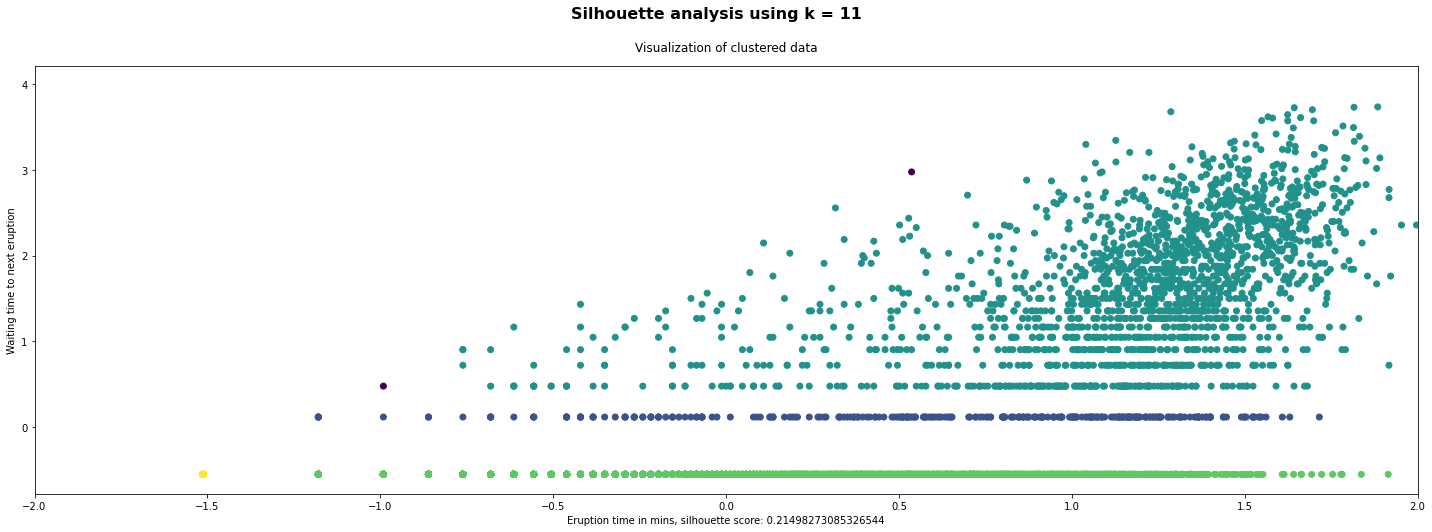

In [70]:
selected_features: List[str] = ['purchases_count', 'refunds_count']
variable_columns: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features))[0]
selected_data = cluster_data[:, variable_columns]

plot_silhouette_dbscan(selected_data)

In [38]:
selected_features: List[str] = ['purchases_count', 'purchases_value', 'refunds_count', 'refunds_value', 'avg_product_cost']
variable_columns: Tuple[int, ...] = np.where(np.isin(profile_variables, selected_features))[0]
selected_data = cluster_data[:, variable_columns]

dbscan = DBSCAN(eps = 0.3, min_samples = 2)
labels = dbscan.fit_predict(selected_data)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(selected_data, labels))

Estimated number of clusters: 104
Estimated number of noise points: 338
Silhouette Coefficient: -0.418


In [53]:
results: Dict[str, float] = {}
for subset in all_subsets(range(cluster_data.shape[1])):
    if len(subset) > 0:
        print('Computing for features:', itemgetter(*subset)(profile_variables))
        
        dbscan = DBSCAN(eps = 0.3, min_samples = 2)
        labels = dbscan.fit_predict(selected_data)
        labels = dbscan.labels_
        silhouette_score = metrics.silhouette_score(cluster_data[:, subset], labels)
        results[itemgetter(*subset)(profile_variables)] = silhouette_score
        
        print('Score: ', silhouette_score)

Computing for features: recency
Score:  -0.9267404320908406
Computing for features: purchases_count
Score:  -0.8166902164029
Computing for features: purchases_value
Score:  -0.8904351665860962
Computing for features: refunds_count
Score:  -0.23031171914023055
Computing for features: refunds_value
Score:  -0.2935516195770947
Computing for features: avg_product_cost
Score:  -0.9131604375153662
Computing for features: time_between_purchases
Score:  -0.8192680163792184
Computing for features: ('recency', 'purchases_count')
Score:  -0.7875940644121263
Computing for features: ('recency', 'purchases_value')
Score:  -0.87807281799909
Computing for features: ('recency', 'refunds_count')
Score:  -0.8686428839487645
Computing for features: ('recency', 'refunds_value')
Score:  -0.7303303048387372
Computing for features: ('recency', 'avg_product_cost')
Score:  -0.8272378000218497
Computing for features: ('recency', 'time_between_purchases')
Score:  -0.8063717155024605
Computing for features: ('purc

Score:  -0.4945346578785492
Computing for features: ('recency', 'refunds_count', 'refunds_value', 'time_between_purchases')
Score:  -0.5325726686006795
Computing for features: ('recency', 'refunds_count', 'avg_product_cost', 'time_between_purchases')
Score:  -0.6136391690407949
Computing for features: ('recency', 'refunds_value', 'avg_product_cost', 'time_between_purchases')
Score:  -0.5177995543840894
Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'refunds_value')
Score:  -0.4611490393673043
Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'avg_product_cost')
Score:  -0.6093736832226067
Computing for features: ('purchases_count', 'purchases_value', 'refunds_count', 'time_between_purchases')
Score:  -0.6620698627832579
Computing for features: ('purchases_count', 'purchases_value', 'refunds_value', 'avg_product_cost')
Score:  -0.5009840396027129
Computing for features: ('purchases_count', 'purchases_value', 'refunds_value',

In [66]:
results_df = pd.DataFrame.from_dict(results, orient='index')

results_df.columns = ['Silhouette Score']

results_df.sort_values(by= 'Silhouette Score', ascending= False)

Silhouette Score
refunds_count                                           -0.230312
(refunds_count, refunds_value)                          -0.242720
refunds_value                                           -0.293552
(purchases_value, refunds_count, refunds_value)         -0.350726
(purchases_value, refunds_value)                        -0.399597
...                                                           ...
(recency, refunds_count)                                -0.868643
(recency, purchases_value)                              -0.878073
purchases_value                                         -0.890435
avg_product_cost                                        -0.913160
recency                                                 -0.926740

[127 rows x 1 columns]

## DBScan -  Conclusion

DBScan performed quite poorly, showing a very poor degree of separation between clusters, with its negative silhouette score indicating a high degree or spillover. 

Again, the result was expected given the data seems to be quasi-linearly separable (linear hyperplanes), with the clustered data plots showcasing several points whose cluster seems to be incorrectly assigned.

# Conclusion

The purpupose of this section was to generate a set of customer groups by exploring the customer similarities using clustering techniques.

The analysis resulted in the identification of 4 clusters:

### Cluster 0 - Average Joes

The first cluster is the most representative cluster, with **3.092 customers**. TThe cluster's members showcase a typical or average overall behavior, representing an intermmediary purchase number, value, product cost and time between purchases.

For this reason, we named the cluster **"Average Joes"**.

| Variable | Value | 
| --- | --- | 
| Customers Number | 3095 | 
| Average Purchase Number |215.3 |
| Average Purchase Value | 4996.1 |
| Average Refunds Count | 0 |
| Average Refunds Value | 0 |
| Average Product Cost | 8 |
| Average Recency | 89 |
| Average Time Between Purchases | 15 |

Product characteristics: 
- country codes 3 and 2
- product family 5, 22, 17, 7
- company area 5, 19, 15, 7




### Cluster 1 - Overthinkers on a budget

The cluster represents users with the **highest time between purchases**, showcasing a small average purchase number and value, in addition to the lower average product cost. For this reason, we named this group as the **"Overthinkers on a budget"** group. They likely represent monthly restocks for disposable low-cost products, with each unit sold representing a package of several small products (e.g. one package containing multiple bandages).

| Variable | Value |
| --- | --- | 
| Customers Number | 2979 |
| Average Purchase Number | 18 |
| Average Purchase Value | 1392 |
| Average Refunds Count | 0 |
| Average Refunds Value | 0 |
| Average Product Cost | 2 |
| Average Recency | 153 |
| Average Time Between Purchases | 30 |

Product characteristics: 
- country codes 2
- product family 5, 17, 22, 16
- company area 5, 15, 19, 14



### Cluster 3 - Frequent Shoppers

Cluster associated with users which make the **most purchases**, with each purchase having a **very high value**, on average.
The cluster does showcase some refunds, which are offset by the high purchases not associated with refunds.

For these reasons, the cluster has been deemed the **"Frequent Shoppers"** group.

| Variable | Value | 
| --- | --- |
| Customers Number | 1919 |
| Average Purchase Number |1748 |
| Average Purchase Value | 48744 |
| Average Refunds Count | 32 |
| Average Refunds Value | 372 |
| Average Product Cost | 40 |
| Average Recency | 6 |
| Average Time Between Purchases | 1 |

Product characteristics: 
- country codes 2
- product family 5, 22, 7, 16
- company area 5, 19, 7, 15



### Cluster 2 - Unsatisfied Customers

The customers associated **mostly with refunds**. Although very small (only 2 customers) we opted for maintaining the cluster given it can act as a customers flag, tagging elements in need of special attention to attempt to re-capture their trust, or understand what is driving these refunds.

Cluster name: **Unsatisfied Customers**

| Variable | Value | 
| --- | --- | 
| Customers Number | 2 |
| Average Purchase Number |626 |
| Average Purchase Value | -1523 |
| Average Refunds Count | 310 |
| Average Refunds Value | 2187 |
| Average Product Cost | 56 |
| Average Recency | 258 |
| Average Time Between Purchases | 0 |

Product characteristics: 
- country codes 2
